In [159]:
att_cnn_bilstm_cross_validate_model_path = "saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5"
cnn_bilstm_cross_validate_model_path = "saved_model/best_CNN_BiLSTM_Cross_validation.hdf5"
cnn_cross_validate_model_path = "saved_model/best_CNN_Cross_validation.hdf5"
bisltm_cross_validate_model_path = "saved_model/best_BiLSTM_Cross_validation.hdf5"

# defining the hyperparameters
learning_rate = 1e-3
learning_decay = 1e-10 # 1e-4
batch_size= 64 # 128
epochs = 10

spa_dropout_ratio = 0.2 # dropout ration, dropping a entire feature map
kernel_size = 3 # [1,2,3,5] # [1,2,3,5] Size of the kernel. Mixing kernels of various sizes.
                # specifying the length of the 1D convolution window.
dense_units = 64 # hidden unit 128 the number of neurons in the hidden layer
dropout_ratio = 0.1 # 0.1 Dropout Ratio
num_filters = 50 # 36, 128, 256 number of kernels, conv_size
                # Integer, the dimensionality of the output space (i.e. the number of output filters in the convolution).

lstm_units_1 = 64 # the size(dim) of the hidden state vector as well as the output vector.
lstm_units_2 = 32 # the size(dim) of the hidden state vector as well as the output vector.
embed_dim = 300 

import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputSpec, Layer, Input, Embedding, Conv1D, Conv2D, Bidirectional, Dense, Attention
from tensorflow.keras.layers import LSTM, Activation, Add, Flatten, Concatenate, concatenate # CuDNNGRU, CuDNNLSTM, 
from tensorflow.keras.layers import Reshape, Dropout, SpatialDropout1D, BatchNormalization
from tensorflow.keras.layers import MaxPooling1D, MaxPool2D, GlobalAveragePooling1D, GlobalMaxPooling1D, GlobalMaxPool1D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K 
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping, CSVLogger
from tensorflow.keras.optimizers import Adam

import string
# from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer, WordNetLemmatizer

from glob import glob
from tqdm import tqdm

from time import time
from timeit import default_timer as timer
from datetime import datetime

import re, copy
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report



In [160]:
import pandas as pd
import numpy as np
train_set = pd.read_csv("/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/v11/wordnet/wordnet_1/wordnet_80_percent_1.csv", header= None,names=["text", "label"])
test_unseen = pd.read_csv("/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/v11/wordnet/wordnet_1/wordnet_20_percent_1.csv",  header= None,names=["text", "label"])

# all_dataset =  pd.read_csv("/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/v11/original/original_1/original_dataset.csv",  header= None,names=["text", "label"])

In [161]:
from sklearn.model_selection import train_test_split
message_train, message_test, label_train, label_test = train_test_split(train_set["text"], train_set["label"], test_size=0.15,stratify=train_set["label"])

test = pd.DataFrame()
test["text"]=message_test
test["label"]=label_test


In [162]:
message_train_2, message_validation, label_train_2, label_validation = train_test_split(message_train, label_train, test_size=0.1765,stratify=label_train)
train = pd.DataFrame()
train["text"]=message_train_2
train["label"]=label_train_2

validate = pd.DataFrame()
validate["text"]=message_validation
validate["label"]=label_validation

In [163]:
validate["label"].value_counts()

label
ขอเอกสาร/ใบรับรอง           682
ลงทะเบียนเรียน              565
ชำระเงิน/ใบเสร็จรับเงิน     516
แจ้งจบ/ขึ้นทะเบียนบัณฑิต    258
เกรด                         88
ประวัตินักศึกษา              84
สถานภาพนักศึกษา              71
Name: count, dtype: int64

In [164]:
train["label"].value_counts()

label
ขอเอกสาร/ใบรับรอง           3184
ลงทะเบียนเรียน              2633
ชำระเงิน/ใบเสร็จรับเงิน     2409
แจ้งจบ/ขึ้นทะเบียนบัณฑิต    1201
เกรด                         408
ประวัตินักศึกษา              394
สถานภาพนักศึกษา              330
Name: count, dtype: int64

In [165]:
test_unseen["label"].value_counts()

label
ขอเอกสาร/ใบรับรอง           1137
ลงทะเบียนเรียน               941
ชำระเงิน/ใบเสร็จรับเงิน      861
แจ้งจบ/ขึ้นทะเบียนบัณฑิต     429
เกรด                         146
ประวัตินักศึกษา              140
สถานภาพนักศึกษา              118
Name: count, dtype: int64

In [166]:
test["label"].value_counts()

label
ขอเอกสาร/ใบรับรอง           683
ลงทะเบียนเรียน              565
ชำระเงิน/ใบเสร็จรับเงิน     516
แจ้งจบ/ขึ้นทะเบียนบัณฑิต    258
เกรด                         87
ประวัตินักศึกษา              84
สถานภาพนักศึกษา              71
Name: count, dtype: int64

In [167]:
# all_dataset["label"].value_counts()

In [168]:
!pip install sklearn_crfsuite
!pip install https://github.com/PyThaiNLP/pythainlp/archive/dev.zip
# !pip install fastai=÷=1.0.46

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
# nltk.download('punkt')
# nltk.download('stopwords')
from pythainlp.corpus import thai_stopwords
stopwords = thai_stopwords()

zsh:1: /Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/bin/pip: bad interpreter: /Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification-using-novel-CNN-Bi-LSTM-framework/venv/bin/python3.11: no such file or directory


You are using pip version 18.1, however version 20.3.4 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
zsh:1: /Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/bin/pip: bad interpreter: /Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification-using-novel-CNN-Bi-LSTM-framework/venv/bin/python3.11: no such file or directory
  Using cached https://github.com/PyThaiNLP/pythainlp/archive/dev.zip
  Installing build dependencies ... done
pythainlp requires Python '>=3.7' but the running Python is 2.7.16
You are using pip version 18.1, however version 20.3.4 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [169]:

# from pythainlp.corpus import thai_stopwords
from pythainlp import word_tokenize

def lower_text(text):
    return text.lower()

def remove_number(text):
    num = re.compile(r'[-+]?[.\d]*[\d]+[:,.\d]*')
    return num.sub(r'', text)

def remove_punct(text):
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`"
    for p in punctuations:
        text = text.replace(p, f' {p} ')
    return text

def remove_stopwords(text):
    text = ' '.join([word for word in word_tokenize(text,engine='newmm') if word not in (stopwords)])
    return text

In [170]:
def clean_text(text):
    # print(text)
    # text = lower_text(text)
    text_str = str(text)
    text = remove_number(text_str)
    text = remove_punct(text_str)
    text = remove_stopwords(text_str)

    return text

In [171]:
# all_dataset["clean_text"] = all_dataset["text"].apply(clean_text)
test_unseen["clean_text"] = test_unseen["text"].apply(clean_text)
train["clean_text"] = train["text"].apply(clean_text)
test["clean_text"] = test["text"].apply(clean_text)
validate["clean_text"] =  validate["text"].apply(clean_text)

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
# all_dataset["encoded_original_label"] = label_encoder.fit_transform(all_dataset["label"])
test_unseen["encoded_original_label"] = label_encoder.fit_transform(test_unseen["label"])
test["encoded_original_label"] = label_encoder.fit_transform(test["label"])
train["encoded_original_label"] = label_encoder.fit_transform(train["label"])
validate["encoded_original_label"] = label_encoder.fit_transform(validate["label"])

In [172]:
from keras.utils import to_categorical

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
from keras import layers
from keras.models import Sequential


act= "relu"
opt= tf.keras.optimizers.Adam(learning_rate=0.001)

In [173]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


In [174]:
!pip3 install textblob  

zsh:1: /Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/bin/pip3: bad interpreter: /Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification-using-novel-CNN-Bi-LSTM-framework/venv/bin/python3.11: no such file or directory

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip


## Feed-Forward Networks with Attention Can Solve Some Long-Term Memory Problems
###### https://arxiv.org/abs/1512.08756

In [175]:
class Attention(Layer):
    """
    Keras Layer that implements an Attention mechanism for temporal data.
    Supports Masking.
    Follows the work of Raffel et al. [https://arxiv.org/abs/1512.08756]
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    :param kwargs:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(Attention())
    """
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None
        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim
        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))
        if self.bias:
            eij += self.b
        eij = K.tanh(eij)
        a = K.exp(eij)
        if mask is not None:
            a *= K.cast(mask, K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

## Hierarchical Attention Networks for Document Classification
##### http://www.cs.cmu.edu/~./hovy/papers/16HLT-hierarchical-attention-networks.pdf

In [176]:
# https://towardsdatascience.com/nlp-learning-series-part-3-attention-cnn-and-what-not-for-text-classification-4313930ed566
# https://www.kaggle.com/code/duykhanh99/bidirectional-lstm-cnn-attention-model/notebook
    
def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)
    
    
def create_custom_objects():
    instance_holder = {"instance": None}

    class ClassWrapper(AttentionWithContext):
        def __init__(self, *args, **kwargs):
            instance_holder["instance"] = self
            super(ClassWrapper, self).__init__(*args, **kwargs)

    def loss(*args):
        method = getattr(instance_holder["instance"], "loss_function")
        return method(*args)

    def accuracy(*args):
        method = getattr(instance_holder["instance"], "accuracy")
        return method(*args)
    return {"ClassWrapper": ClassWrapper ,"AttentionWithContext": ClassWrapper, "loss": loss,
            "accuracy":accuracy}


class AttentionWithContext(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Note: The layer has been tested with Keras 2.0.6
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """

    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)
        
#     def get_config(self):
#         config = super().get_config()
#         config.update({
#             "arg1": self.arg1,
#             "arg2": self.arg2,
#         })
#         return config     
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
                'W_regularizer': self.W_regularizer,
                'u_regularizer': self.u_regularizer,
                'b_regularizer': self.b_regularizer,
                'W_constraint': self.W_constraint,
                'u_constraint': self.u_constraint,
                'b_constraint': self.b_constraint,
                'bias': self.bias,
        })
        return config

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight(shape=(input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)

        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

# Training the models

In [177]:
# Setting up our results dataframe
df_results = pd.DataFrame(columns=['F1_score', 'Precision', 'Recall', 'Accuracy', 'Training time'])
df_results_cross_val = pd.DataFrame(columns=['F1_score', 'Precision', 'Recall', 'Accuracy', 'Training time'])

In [178]:
test["encoded_original_label"]

8237     1
3178     3
9253     1
11858    3
4792     0
        ..
13459    0
4046     0
9000     6
4549     6
644      1
Name: encoded_original_label, Length: 2264, dtype: int64

In [179]:
X_train, X_test_unseen, X_test, X_validate = train["clean_text"], test_unseen["clean_text"], test["clean_text"], validate["clean_text"]


y_train, y_test_unseen, y_test, y_validate = train["encoded_original_label"], test_unseen["encoded_original_label"],test["encoded_original_label"],validate["encoded_original_label"]


temp_X_train, temp_X_test_unseen,temp_X_test,temp_X_validate, temp_y_train, temp_y_test_unseen,temp_y_test,temp_y_validate = X_train, X_test_unseen,  X_test, X_validate, y_train, y_test_unseen,y_test,y_validate

# temp_message, temp_label = all_dataset["clean_text"], all_dataset["encoded_original_label"]

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test_unseen = tokenizer.texts_to_sequences(X_test_unseen)
X_test = tokenizer.texts_to_sequences(X_test)
X_validate = tokenizer.texts_to_sequences(X_validate)

vocab_size = len(tokenizer.word_index) + 1
MAX_NB_WORDS = vocab_size
print(tokenizer.word_index)

max_length=max([len(i) for i in X_train])
print('Max len:', max_length)

X_train = pad_sequences(X_train, padding='post', maxlen=max_length)
X_test_unseen = pad_sequences(X_test_unseen, padding='post', maxlen=max_length)
X_test = pad_sequences(X_test, padding='post', maxlen=max_length)
X_validate = pad_sequences(X_validate, padding='post', maxlen=max_length)

y_test_unseen = to_categorical(y_test_unseen)
y_test = to_categorical(y_test)
y_train = to_categorical(y_train)
y_validate = to_categorical(y_validate)

### Cross validation ###
# X_train, y_train = temp_message, temp_label
# tokenizer_cross_val = Tokenizer()
# tokenizer_cross_val.fit_on_texts(X_train)

# X_train = tokenizer_cross_val.texts_to_sequences(X_train)

# vocab_size_cross_val = len(tokenizer_cross_val.word_index) + 1
# MAX_NB_WORDS = vocab_size_cross_val

# X_train = pad_sequences(X_train, padding='post', maxlen=max_length)
# y_train = to_categorical(y_train)

{'ค่า': 1, 'เอกสาร': 2, 'หรอ': 3, 'จ่าย': 4, 'จุด': 5, 'เทอม': 6, 'ไหม': 7, 'ถอน': 8, 'ซักไซ้': 9, 'ใบ': 10, 'วิชา': 11, 'เป็นนิสัย': 12, 'ตีพิมพ์': 13, 'หนู': 14, 'แจ้ง': 15, 'ผม': 16, 'ต้องการ': 17, 'อะ': 18, 'ขึ้นทะเบียน': 19, 'ลงทะเบียน': 20, 'เรื่อง': 21, 'ชำระ': 22, 'สวัสดี': 23, 'ประกาศนียบัตร': 24, 'ออนไลน์': 25, 'tu': 26, 'ทำ': 27, 'บัณฑิต': 28, 'นักศึกษา': 29, 'ไห': 30, 'นคะ': 31, 'กี่': 32, 'เรียน': 33, 'รายวิชา': 34, 'กด': 35, 'เงิน': 36, 'ภาคเรียน': 37, 'ตอนนี้': 38, 'ชำระเงิน': 39, 'แบบนี้': 40, 'ดีกรี': 41, 'รอ': 42, 'ป': 43, 'จดทะเบียน': 44, 'อ่ะ': 45, 'เบิก': 46, 'reg': 47, 'หน่วยกิต': 48, 'โควต้า': 49, 'ตอน': 50, 'ภาวะ': 51, 'นะคะ': 52, 'ชั่วโมง': 53, 'จบ': 54, 'transcript': 55, 'ตรวจสอบ': 56, 'ยื่น': 57, 'คณะ': 58, 'อันนี้': 59, 'เกาะ': 60, 'ซัมเมอร์': 61, 'ล่าช้า': 62, 'วันที่': 63, 'ทราบ': 64, 'มูลค่า': 65, 'ชั้น': 66, 'ศาสตร์': 67, 'หนังสือรับรอง': 68, 'w': 69, 'ค': 70, 'ฐานะ': 71, 'ท': 72, 'ติดต่อ': 73, 'รหัส': 74, 'เดินทาง': 75, 'บิล': 76, 'ทางไปรษณีย์': 77, 'กา

In [180]:
train["label"].value_counts()

label
ขอเอกสาร/ใบรับรอง           3184
ลงทะเบียนเรียน              2633
ชำระเงิน/ใบเสร็จรับเงิน     2409
แจ้งจบ/ขึ้นทะเบียนบัณฑิต    1201
เกรด                         408
ประวัตินักศึกษา              394
สถานภาพนักศึกษา              330
Name: count, dtype: int64

## Att CNN-BiLSTM MODEL

In [181]:
def build_model_1(lr=0.0, lr_d=0.0, spatial_dr=0.0, kernel_size=3,
                  dense_units=128, dropout_ratio=0.0, num_filters=32,
                  lstm_units_1=0, lstm_units_2=0, batch_size=64, epochs=10):
    
    model_input = Input(shape=(max_length,))
    
    ######################## EMBEDDING LAYER ###############################################
    # embed MAX_NB_WORDS words into a embed_dim vector. (e.g. For fasttext, the embed__dim is 300)
    x = Embedding(
        MAX_NB_WORDS, 
        embed_dim, 
        input_length=max_length,
        name = "embedding"
        )(model_input)
            
    # dropout operation
#     x = Dropout(dropout_ratio)(x)
    x = SpatialDropout1D(spatial_dr)(x)
    
    ######################## CNN LAYER(S) ###############################################
    ## one kernel
#     conv = Conv1D(
#         filters = num_filters,
#         kernel_size=,
#         padding = "valid",
# #         kernel_initializer='he_uniform',
# #         kernel_initializer='he_normal',
#         activation = "relu",
#         strides=1
#     )(x)
    conv = Conv1D(filters=num_filters, kernel_size=kernel_size, padding="valid", activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(conv)
    
#     ## multiple kernels
#     maxpool_pool = []
#     for sz in kernel_size:
#         print("kernel ... ",sz)
#         conv = Conv1D(
#             filters = num_filters,
#             kernel_size = sz,
# #             padding = "valid",
#             padding = "same", # Use 'same' padding so outputs have the same shape as inputs.
#             kernel_initializer='he_uniform',
# #             kernel_initializer='he_normal',
#             activation = "relu",
#             strides = 1
#         )(x)
        
#         ## pooling operations
# #         conv = GlobalMaxPooling1D()(conv)
# #         conv = GlobalAveragePooling1D()(conv)
# #         conv = MaxPool1D(pool_size=(maxlen - filter_sizes[sz] + 1, 1))(conv)
# #         maxpool_pool.append(conv)

#         maxpool_pool.append(GlobalMaxPooling1D()(conv))
#         maxpool_pool.append(GlobalAveragePooling1D()(conv))

#     ## Concatenates each maxpooled result and send it to the BiLSTM layer
# #     x = concatenate()(maxpool_pool) if len(maxpool_pool) > 1 else maxpool_pool[0]
#     x = Concatenate(axis=1)(maxpool_pool)
# #     x = concatenate(maxpool_pool)  # yes or no
    
# #     x = BatchNormalization()(x) # yes or no
# #     x = Flatten()(x) # yes or no
    
    x = Dropout(dropout_ratio)(x) # yes or no
    
#     x = Dense(dense_units, activation = "relu")(x) # yes or no  
#     x = BatchNormalization()(x) # yes or no
    
    ######################## BiLSTM LAYER(S) ################################################
#     x = Bidirectional(LSTM(lstm_units, return_sequences=True))(x)
    # CuDNNLSTm can be implemented instead of LSTM, it is just implementations of LSTM that are created to run faster on GPUs
    x = Bidirectional(LSTM(lstm_units_1, return_sequences=True))(x)
    x = Bidirectional(LSTM(lstm_units_2, return_sequences=True))(x) # yes or no
#     avg_pool = GlobalAveragePooling1D()(x)  # yes or no
#     max_pool = GlobalMaxPooling1D()(x)  # yes or no
#     x = concatenate([avg_pool, max_pool])  # yes or no
#     x = Dense(64, activation="relu")(x)

#     x = Dropout(dropout_ratio)(x) # yes or no    

#     x = Bidirectional(LSTM(64, return_sequences=True))(x)
#     avg_pool = GlobalAveragePooling1D()(x)
#     max_pool = GlobalMaxPooling1D()(x)
#     conc = concatenate([avg_pool, max_pool])
#     conc = Dense(64, activation="relu")(conc)
#     x = Dropout(0.1)(conc)
    
    ######################## ATTENTION LAYER ################################################
    # use Attention operation, with a context/query vector, for temporal data.
    x = AttentionWithContext()(x)
    x = Dense(dense_units, activation='relu')(x)  
    x = Dropout(dropout_ratio)(x)

    # The attention using Bahdanau attention.
#     attention = BahdanauAttention(lstm_units_2) # Weight Size Definition
#     context_vector, attention_weights = attention(lstm, state_h)

    # use Attention mechanism for temporal data.
#     x = Attention(max_length)(x)
#     x = GlobalMaxPooling1D()(x) # yes or no    
#     x = GlobalAveragePooling1D()(x) # yes or no    
#     x = Dropout(dropout_ratio)(x)
#     x = Dense(64, activation='relu')(x)
#     x = Dropout(dropout_ratio)(x)

    ######################## CLASSIFICATION LAYER ###########################################
    model_output = Dense(7, activation="softmax")(x)
    model = Model(model_input, model_output)
    
    ######################## COMPILING THE MODEL ##################################
    model.compile(
        loss = "categorical_crossentropy", 
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr, decay=lr_d),
#         optimizer='adam',
        metrics = [
            "accuracy",
#             "binary_accuracy",
#              'categorical_accuracy' ,
#             tf.keras.metrics.AUC(),
#             tf.keras.metrics.Precision(),
#             tf.keras.metrics.Recall()
            ]
        )
    
    ######################## MODEL SAVING/OVERFITTING MANAGEMENT ##################################
    model_path = "saved_model/best_Attention_CNN_BiLSTM_"+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + ".hdf5"
    check_point = ModelCheckpoint(model_path, monitor="val_loss", verbose=1, save_best_only=True, mode="min")
    early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=3, verbose=1,)
    
    # Display a summary of the models structure
    print(model.summary())
    print("#"*80)
    tf.keras.utils.plot_model(model, to_file="Att_cnn_BiLSTM_architecture_"+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + ".png", show_shapes=True)
    
    ######################## TRAINING THE MODEL ##################################
    start_time = time()
    history_1 = model.fit(
        X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_validate, y_validate),
        callbacks=[check_point,early_stop])
    train_time = time() - start_time
    print(train_time)

#     model = load_model(model_path)
    model = load_model(model_path, custom_objects=create_custom_objects())
    
    ######################## EVALUATING THE MODEL ##################################  
    model.evaluate(X_test_unseen, y_test_unseen) # or model.predict
    
    return model, history_1, train_time

In [182]:
# Train proposed model
model_1, history_1, train_time = build_model_1(lr=learning_rate, lr_d=learning_decay, spatial_dr=spa_dropout_ratio, kernel_size=kernel_size,
                                            dense_units=dense_units, dropout_ratio=dropout_ratio, num_filters=num_filters, lstm_units_1=lstm_units_1,
                                            lstm_units_2=lstm_units_2, batch_size=batch_size, epochs=epochs
                                           )

Model: "model_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_45 (InputLayer)       [(None, 15)]              0         
                                                                 
 embedding (Embedding)       (None, 15, 300)           576600    
                                                                 
 spatial_dropout1d_66 (Spat  (None, 15, 300)           0         
 ialDropout1D)                                                   
                                                                 
 conv1d_55 (Conv1D)          (None, 13, 50)            45050     
                                                                 
 max_pooling1d_55 (MaxPooli  (None, 6, 50)             0         
 ng1D)                                                           
                                                                 
 dropout_110 (Dropout)       (None, 6, 50)             0  

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


165/165 [==============================] - ETA: 0s - loss: 1.0149 - accuracy: 0.6095
Epoch 1: val_loss improved from inf to 0.38864, saving model to saved_model/best_Attention_CNN_BiLSTM_20240210_16-18-22.hdf5
165/165 [==============================] - 5s 14ms/step - loss: 1.0149 - accuracy: 0.6095 - val_loss: 0.3886 - val_accuracy: 0.8591
Epoch 2/10
 16/165 [=>............................] - ETA: 1s - loss: 0.3132 - accuracy: 0.8848

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


161/165 [============================>.] - ETA: 0s - loss: 0.2645 - accuracy: 0.9104
Epoch 2: val_loss improved from 0.38864 to 0.20227, saving model to saved_model/best_Attention_CNN_BiLSTM_20240210_16-18-22.hdf5
165/165 [==============================] - 2s 11ms/step - loss: 0.2630 - accuracy: 0.9105 - val_loss: 0.2023 - val_accuracy: 0.9271
Epoch 3/10
162/165 [============================>.] - ETA: 0s - loss: 0.1499 - accuracy: 0.9496
Epoch 3: val_loss improved from 0.20227 to 0.13417, saving model to saved_model/best_Attention_CNN_BiLSTM_20240210_16-18-22.hdf5
165/165 [==============================] - 2s 11ms/step - loss: 0.1498 - accuracy: 0.9497 - val_loss: 0.1342 - val_accuracy: 0.9655
Epoch 4/10
161/165 [============================>.] - ETA: 0s - loss: 0.0957 - accuracy: 0.9719
Epoch 4: val_loss improved from 0.13417 to 0.10337, saving model to saved_model/best_Attention_CNN_BiLSTM_20240210_16-18-22.hdf5
165/165 [==============================] - 2s 11ms/step - loss: 0.0954 -

In [183]:

# Test 15%
predicted = model_1.predict(X_test)

predicted = np.argmax(predicted, axis=1)
y_test = np.argmax(y_test,axis=1)

# report = classification_report(y_test_unseen, predicted, output_dict=True)
report = classification_report(y_test, predicted, digits=4)
print(report)


# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, predicted)
print('Testing Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, predicted,average='weighted')
print('Testing Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, predicted,average='weighted')
print('Testing Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, predicted,average='weighted')
print('Testing F1 score: %f' % f1)


71/71 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0     0.9770    0.9971    0.9870       683
           1     0.9902    0.9787    0.9844       516
           2     0.9625    0.9167    0.9390        84
           3     0.9824    0.9858    0.9841       565
           4     1.0000    0.9577    0.9784        71
           5     0.9659    0.9770    0.9714        87
           6     0.9961    0.9806    0.9883       258

    accuracy                         0.9832      2264
   macro avg     0.9820    0.9705    0.9761      2264
weighted avg     0.9833    0.9832    0.9832      2264

Testing Accuracy: 0.983216
Testing Precision: 0.983289
Testing Recall: 0.983216
Testing F1 score: 0.983170


In [184]:

df_results.loc['Att-Based CNN-BiLSTM Test 15%'] = [f1, precision, recall, accuracy, train_time]
df_results

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM Test 15%,0.98317,0.983289,0.983216,0.983216,20.757635


Validate 15%

In [185]:
predicted_val = model_1.predict(X_validate)

predicted_val = np.argmax(predicted_val, axis=1)
y_validate = np.argmax(y_validate,axis=1)

report = classification_report(y_validate, predicted_val, digits=4)
print(report)

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_validate, predicted_val)
print('Testing Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_validate, predicted_val,average='weighted')
print('Testing Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_validate, predicted_val,average='weighted')
print('Testing Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_validate, predicted_val,average='weighted')
print('Testing F1 score: %f' % f1)

71/71 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0     0.9783    0.9912    0.9847       682
           1     0.9922    0.9806    0.9864       516
           2     0.9877    0.9524    0.9697        84
           3     0.9788    0.9805    0.9797       565
           4     1.0000    0.9859    0.9929        71
           5     0.9778    1.0000    0.9888        88
           6     0.9805    0.9729    0.9767       258

    accuracy                         0.9828      2264
   macro avg     0.9850    0.9805    0.9827      2264
weighted avg     0.9828    0.9828    0.9828      2264

Testing Accuracy: 0.982774
Testing Precision: 0.982835
Testing Recall: 0.982774
Testing F1 score: 0.982764


In [186]:
df_results.loc['Att-Based CNN-BiLSTM Validate 15%'] = [f1, precision, recall, accuracy, train_time]
df_results

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM Test 15%,0.983170,0.983289,0.983216,0.983216,20.757635
Att-Based CNN-BiLSTM Validate 15%,0.982764,0.982835,0.982774,0.982774,20.757635


In [187]:
print(X_test_unseen)

[[  58  224  413 ...    0    0    0]
 [ 551  188    0 ...    0    0    0]
 [   9    8   34 ...    0    0    0]
 ...
 [ 233 1654  514 ...    0    0    0]
 [   4  175  340 ...    0    0    0]
 [  44   11    7 ...    0    0    0]]


In [188]:
# Test unseen 15%

predicted_test_unseen = model_1.predict(X_test_unseen)
print(predicted_test_unseen)
predicted_test_unseen = np.argmax(predicted_test_unseen, axis=1)
y_test_unseen = np.argmax(y_test_unseen,axis=1)

# report = classification_report(y_test_unseen, predicted, output_dict=True)
report = classification_report(y_test_unseen, predicted_test_unseen, digits=4)
print(report)

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test_unseen, predicted_test_unseen)
print('Testing Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test_unseen, predicted_test_unseen,average='weighted')
print('Testing Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test_unseen, predicted_test_unseen,average='weighted')
print('Testing Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test_unseen, predicted_test_unseen,average='weighted')
print('Testing F1 score: %f' % f1)

118/118 [==============================] - 0s 1ms/step
[[6.77454955e-05 2.27114814e-03 2.67093651e-06 ... 2.52159737e-07
  6.98197546e-05 4.79626251e-05]
 [7.91713968e-02 8.93026352e-01 1.58413651e-03 ... 1.28808111e-04
  1.03112205e-03 9.22440458e-03]
 [1.06614636e-04 2.59802607e-03 1.24661010e-05 ... 9.19484876e-07
  6.67890359e-04 1.71618507e-04]
 ...
 [4.23136808e-05 9.99574840e-01 6.83381131e-06 ... 7.10944192e-08
  6.21953586e-05 6.20004648e-05]
 [2.12250845e-04 9.98695195e-01 3.39217440e-05 ... 6.67696611e-07
  2.06606492e-04 2.73482408e-04]
 [1.58165611e-04 2.93591316e-03 7.03621208e-06 ... 9.95256414e-07
  1.60867930e-04 1.39253592e-04]]
              precision    recall  f1-score   support

           0     0.9708    0.9947    0.9826      1137
           1     0.9928    0.9675    0.9800       861
           2     0.9787    0.9857    0.9822       140
           3     0.9830    0.9819    0.9825       941
           4     0.9915    0.9831    0.9872       118
           5     0.9

In [189]:
df_results.loc['Att-Based CNN-BiLSTM Test unseen 20%'] = [f1, precision, recall, accuracy, train_time]
df_results

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM Test 15%,0.983170,0.983289,0.983216,0.983216,20.757635
Att-Based CNN-BiLSTM Validate 15%,0.982764,0.982835,0.982774,0.982774,20.757635
Att-Based CNN-BiLSTM Test unseen 20%,0.982501,0.982676,0.982503,0.982503,20.757635


In [190]:
print(X_train)
print()
print(y_train)

[[ 16  82  27 ...   0   0   0]
 [ 66 340 278 ...   0   0   0]
 [ 26  41  13 ...   0   0   0]
 ...
 [ 59 118   5 ...   0   0   0]
 [243  18 107 ...   0   0   0]
 [ 56  11   5 ...   0   0   0]]

[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [191]:
# Define model parameters
# MAX_NB_WORDS = 1000
# embed_dim = 100
# max_length = 100
# spa_dropout_ratio = 0.2
# lstm_units_1 = 64
# lstm_units_2 = 64
# dense_units = 32
# dropout_ratio = 0.5
# learning_rate = 0.001
# learning_decay = 1e-6

# Number of folds
num_folds = 10

# Create a StratifiedKFold object
kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

accuracy_scores_att_cnn_bilstm = []
precision_scores_att_cnn_bilstm = []
f1_scores_att_cnn_bilstm = []
recall_scores_att_cnn_bilstm = []

X, y_encoded = X_train, y_train
total_train_time = 0  # Initialize total training time
# Perform cross-validation]
fold_var = 0
for i, (train_index, test_index) in enumerate(kf.split(X, y_encoded.argmax(1))):
    fold_var +=1
    print("------ Fold ----------", fold_var)
   
    X_train, X_val = X[train_index], X[test_index]
    y_train, y_val = y_encoded[train_index], y_encoded[test_index]
    model_input = Input(shape=(max_length,))
    
    ######################## EMBEDDING LAYER ###############################################
    # embed MAX_NB_WORDS words into a embed_dim vector. (e.g. For fasttext, the embed__dim is 300)
    x = Embedding(
        MAX_NB_WORDS, 
        embed_dim, 
        input_length=max_length,
        name = "embedding"
        )(model_input)
            
    # dropout operation
#     x = Dropout(dropout_ratio)(x)
    x = SpatialDropout1D(spa_dropout_ratio)(x)
    
    ######################## CNN LAYER(S) ###############################################
    ## one kernel
#     conv = Conv1D(
#         filters = num_filters,
#         kernel_size=,
#         padding = "valid",
# #         kernel_initializer='he_uniform',
# #         kernel_initializer='he_normal',
#         activation = "relu",
#         strides=1
#     )(x)
    conv = Conv1D(filters=num_filters, kernel_size=kernel_size, padding="valid", activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(conv)
    
#     ## multiple kernels
#     maxpool_pool = []
#     for sz in kernel_size:
#         print("kernel ... ",sz)
#         conv = Conv1D(
#             filters = num_filters,
#             kernel_size = sz,
# #             padding = "valid",
#             padding = "same", # Use 'same' padding so outputs have the same shape as inputs.
#             kernel_initializer='he_uniform',
# #             kernel_initializer='he_normal',
#             activation = "relu",
#             strides = 1
#         )(x)
        
#         ## pooling operations
# #         conv = GlobalMaxPooling1D()(conv)
# #         conv = GlobalAveragePooling1D()(conv)
# #         conv = MaxPool1D(pool_size=(maxlen - filter_sizes[sz] + 1, 1))(conv)
# #         maxpool_pool.append(conv)

#         maxpool_pool.append(GlobalMaxPooling1D()(conv))
#         maxpool_pool.append(GlobalAveragePooling1D()(conv))

#     ## Concatenates each maxpooled result and send it to the BiLSTM layer
# #     x = concatenate()(maxpool_pool) if len(maxpool_pool) > 1 else maxpool_pool[0]
#     x = Concatenate(axis=1)(maxpool_pool)
# #     x = concatenate(maxpool_pool)  # yes or no
    
# #     x = BatchNormalization()(x) # yes or no
# #     x = Flatten()(x) # yes or no
    
    x = Dropout(dropout_ratio)(x) # yes or no
    
#     x = Dense(dense_units, activation = "relu")(x) # yes or no  
#     x = BatchNormalization()(x) # yes or no
    
    ######################## BiLSTM LAYER(S) ################################################
#     x = Bidirectional(LSTM(lstm_units, return_sequences=True))(x)
    # CuDNNLSTm can be implemented instead of LSTM, it is just implementations of LSTM that are created to run faster on GPUs
    x = Bidirectional(LSTM(lstm_units_1, return_sequences=True))(x)
    x = Bidirectional(LSTM(lstm_units_2, return_sequences=True))(x) # yes or no
#     avg_pool = GlobalAveragePooling1D()(x)  # yes or no
#     max_pool = GlobalMaxPooling1D()(x)  # yes or no
#     x = concatenate([avg_pool, max_pool])  # yes or no
#     x = Dense(64, activation="relu")(x)

#     x = Dropout(dropout_ratio)(x) # yes or no    

#     x = Bidirectional(LSTM(64, return_sequences=True))(x)
#     avg_pool = GlobalAveragePooling1D()(x)
#     max_pool = GlobalMaxPooling1D()(x)
#     conc = concatenate([avg_pool, max_pool])
#     conc = Dense(64, activation="relu")(conc)
#     x = Dropout(0.1)(conc)
    
    ######################## ATTENTION LAYER ################################################
    # use Attention operation, with a context/query vector, for temporal data.
    x = AttentionWithContext()(x)
    x = Dense(dense_units, activation='relu')(x)  
    x = Dropout(dropout_ratio)(x)

    # The attention using Bahdanau attention.
#     attention = BahdanauAttention(lstm_units_2) # Weight Size Definition
#     context_vector, attention_weights = attention(lstm, state_h)

    # use Attention mechanism for temporal data.
#     x = Attention(max_length)(x)
#     x = GlobalMaxPooling1D()(x) # yes or no    
#     x = GlobalAveragePooling1D()(x) # yes or no    
#     x = Dropout(dropout_ratio)(x)
#     x = Dense(64, activation='relu')(x)
#     x = Dropout(dropout_ratio)(x)

    ######################## CLASSIFICATION LAYER ###########################################
    model_output = Dense(7, activation="softmax")(x)
    att_cnn_bilstm_model = Model(model_input, model_output)

    ######################## COMPILING THE MODEL ##################################
    att_cnn_bilstm_model.compile(
        loss = "categorical_crossentropy", 
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate, decay=learning_decay),
#         optimizer='adam',
        metrics = [
            "accuracy",
            ]
        )
    
    ######################## MODEL SAVING/OVERFITTING MANAGEMENT ##################################
    check_point = ModelCheckpoint(att_cnn_bilstm_cross_validate_model_path, monitor="val_loss", verbose=1, save_best_only=True, mode="min")
    early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=3, verbose=1)
    callbacks_list = [check_point,early_stop]
    
    # Display a summary of the models structure
    print(att_cnn_bilstm_model.summary())
    print("#"*80)
   
    # Train the model
    start_time = time()
    att_cnn_bilstm_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), callbacks=callbacks_list, verbose=1)
    total_train_time += train_time 
    
    y_pred=np.argmax(att_cnn_bilstm_model.predict(X_val), axis=-1)
    y_true_validation_test = np.argmax(y_val,axis = 1)
    
    accuracy_scores_att_cnn_bilstm.append(accuracy_score(y_true_validation_test, y_pred))
    precision_scores_att_cnn_bilstm.append(precision_score(y_true_validation_test, y_pred, average='weighted'))
    f1_scores_att_cnn_bilstm.append(f1_score(y_true_validation_test, y_pred, average='weighted'))
    recall_scores_att_cnn_bilstm.append(f1_score(y_true_validation_test, y_pred, average='weighted'))


------ Fold ---------- 1


Model: "model_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_46 (InputLayer)       [(None, 15)]              0         
                                                                 
 embedding (Embedding)       (None, 15, 300)           576600    
                                                                 
 spatial_dropout1d_67 (Spat  (None, 15, 300)           0         
 ialDropout1D)                                                   
                                                                 
 conv1d_56 (Conv1D)          (None, 13, 50)            45050     
                                                                 
 max_pooling1d_56 (MaxPooli  (None, 6, 50)             0         
 ng1D)                                                           
                                                                 
 dropout_112 (Dropout)       (None, 6, 50)             0  

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


292/297 [============================>.] - ETA: 0s - loss: 0.8804 - accuracy: 0.6812
Epoch 1: val_loss improved from inf to 0.38589, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
297/297 [==============================] - 7s 10ms/step - loss: 0.8715 - accuracy: 0.6852 - val_loss: 0.3859 - val_accuracy: 0.8826
Epoch 2/10
 25/297 [=>............................] - ETA: 1s - loss: 0.3530 - accuracy: 0.9025

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


292/297 [============================>.] - ETA: 0s - loss: 0.2532 - accuracy: 0.9206
Epoch 2: val_loss improved from 0.38589 to 0.19581, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
297/297 [==============================] - 2s 8ms/step - loss: 0.2517 - accuracy: 0.9213 - val_loss: 0.1958 - val_accuracy: 0.9460
Epoch 3/10
290/297 [============================>.] - ETA: 0s - loss: 0.1349 - accuracy: 0.9608
Epoch 3: val_loss improved from 0.19581 to 0.13736, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
297/297 [==============================] - 2s 8ms/step - loss: 0.1327 - accuracy: 0.9616 - val_loss: 0.1374 - val_accuracy: 0.9612
Epoch 4/10
291/297 [============================>.] - ETA: 0s - loss: 0.0877 - accuracy: 0.9732
Epoch 4: val_loss improved from 0.13736 to 0.09778, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
297/297 [==============================] - 2s 7ms/step - loss: 0.0875 - accuracy: 0.9732 - val_

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


294/297 [============================>.] - ETA: 0s - loss: 0.8369 - accuracy: 0.6925
Epoch 1: val_loss improved from inf to 0.29513, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
297/297 [==============================] - 5s 10ms/step - loss: 0.8331 - accuracy: 0.6945 - val_loss: 0.2951 - val_accuracy: 0.9167
Epoch 2/10
 22/297 [=>............................] - ETA: 2s - loss: 0.2375 - accuracy: 0.9361

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


293/297 [============================>.] - ETA: 0s - loss: 0.1871 - accuracy: 0.9443
Epoch 2: val_loss improved from 0.29513 to 0.19818, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
297/297 [==============================] - 2s 8ms/step - loss: 0.1870 - accuracy: 0.9444 - val_loss: 0.1982 - val_accuracy: 0.9422
Epoch 3/10
291/297 [============================>.] - ETA: 0s - loss: 0.1052 - accuracy: 0.9712
Epoch 3: val_loss improved from 0.19818 to 0.16576, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
297/297 [==============================] - 2s 8ms/step - loss: 0.1050 - accuracy: 0.9712 - val_loss: 0.1658 - val_accuracy: 0.9602
Epoch 4/10
290/297 [============================>.] - ETA: 0s - loss: 0.0781 - accuracy: 0.9792
Epoch 4: val_loss did not improve from 0.16576
297/297 [==============================] - 2s 8ms/step - loss: 0.0766 - accuracy: 0.9797 - val_loss: 0.1659 - val_accuracy: 0.9612
Epoch 5/10
296/297 [===================

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


291/297 [============================>.] - ETA: 0s - loss: 0.8832 - accuracy: 0.6687
Epoch 1: val_loss improved from inf to 0.35715, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
297/297 [==============================] - 5s 10ms/step - loss: 0.8729 - accuracy: 0.6734 - val_loss: 0.3571 - val_accuracy: 0.8741
Epoch 2/10
 22/297 [=>............................] - ETA: 2s - loss: 0.3098 - accuracy: 0.8935

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


290/297 [============================>.] - ETA: 0s - loss: 0.2437 - accuracy: 0.9183
Epoch 2: val_loss improved from 0.35715 to 0.19028, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
297/297 [==============================] - 2s 8ms/step - loss: 0.2432 - accuracy: 0.9187 - val_loss: 0.1903 - val_accuracy: 0.9403
Epoch 3/10
296/297 [============================>.] - ETA: 0s - loss: 0.1336 - accuracy: 0.9582
Epoch 3: val_loss improved from 0.19028 to 0.15090, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
297/297 [==============================] - 2s 8ms/step - loss: 0.1339 - accuracy: 0.9581 - val_loss: 0.1509 - val_accuracy: 0.9527
Epoch 4/10
292/297 [============================>.] - ETA: 0s - loss: 0.0912 - accuracy: 0.9732
Epoch 4: val_loss improved from 0.15090 to 0.13141, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
297/297 [==============================] - 2s 8ms/step - loss: 0.0902 - accuracy: 0.9736 - val_

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


296/297 [============================>.] - ETA: 0s - loss: 0.9134 - accuracy: 0.6509
Epoch 1: val_loss improved from inf to 0.29097, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
297/297 [==============================] - 5s 9ms/step - loss: 0.9116 - accuracy: 0.6517 - val_loss: 0.2910 - val_accuracy: 0.9044
Epoch 2/10
 22/297 [=>............................] - ETA: 2s - loss: 0.3464 - accuracy: 0.8793

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


291/297 [============================>.] - ETA: 0s - loss: 0.2287 - accuracy: 0.9297
Epoch 2: val_loss improved from 0.29097 to 0.13903, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
297/297 [==============================] - 2s 8ms/step - loss: 0.2290 - accuracy: 0.9297 - val_loss: 0.1390 - val_accuracy: 0.9574
Epoch 3/10
294/297 [============================>.] - ETA: 0s - loss: 0.1273 - accuracy: 0.9623
Epoch 3: val_loss improved from 0.13903 to 0.09054, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
297/297 [==============================] - 2s 8ms/step - loss: 0.1277 - accuracy: 0.9623 - val_loss: 0.0905 - val_accuracy: 0.9716
Epoch 4/10
297/297 [==============================] - ETA: 0s - loss: 0.0834 - accuracy: 0.9752
Epoch 4: val_loss did not improve from 0.09054
297/297 [==============================] - 2s 8ms/step - loss: 0.0834 - accuracy: 0.9752 - val_loss: 0.0944 - val_accuracy: 0.9706
Epoch 5/10
292/297 [===================

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


292/297 [============================>.] - ETA: 0s - loss: 0.8858 - accuracy: 0.6720
Epoch 1: val_loss improved from inf to 0.33873, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
297/297 [==============================] - 7s 10ms/step - loss: 0.8762 - accuracy: 0.6755 - val_loss: 0.3387 - val_accuracy: 0.8883
Epoch 2/10
 25/297 [=>............................] - ETA: 1s - loss: 0.3051 - accuracy: 0.8963

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


295/297 [============================>.] - ETA: 0s - loss: 0.2336 - accuracy: 0.9225
Epoch 2: val_loss improved from 0.33873 to 0.17579, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
297/297 [==============================] - 2s 8ms/step - loss: 0.2332 - accuracy: 0.9228 - val_loss: 0.1758 - val_accuracy: 0.9470
Epoch 3/10
291/297 [============================>.] - ETA: 0s - loss: 0.1236 - accuracy: 0.9643
Epoch 3: val_loss improved from 0.17579 to 0.12707, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
297/297 [==============================] - 2s 8ms/step - loss: 0.1233 - accuracy: 0.9641 - val_loss: 0.1271 - val_accuracy: 0.9650
Epoch 4/10
295/297 [============================>.] - ETA: 0s - loss: 0.0914 - accuracy: 0.9720
Epoch 4: val_loss improved from 0.12707 to 0.09628, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
297/297 [==============================] - 2s 8ms/step - loss: 0.0912 - accuracy: 0.9722 - val_

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


291/297 [============================>.] - ETA: 0s - loss: 0.9300 - accuracy: 0.6525
Epoch 1: val_loss improved from inf to 0.31510, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
297/297 [==============================] - 5s 10ms/step - loss: 0.9177 - accuracy: 0.6573 - val_loss: 0.3151 - val_accuracy: 0.9034
Epoch 2/10
 22/297 [=>............................] - ETA: 2s - loss: 0.2745 - accuracy: 0.9148

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


296/297 [============================>.] - ETA: 0s - loss: 0.2044 - accuracy: 0.9364
Epoch 2: val_loss improved from 0.31510 to 0.12920, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
297/297 [==============================] - 2s 7ms/step - loss: 0.2039 - accuracy: 0.9367 - val_loss: 0.1292 - val_accuracy: 0.9574
Epoch 3/10
293/297 [============================>.] - ETA: 0s - loss: 0.1018 - accuracy: 0.9699
Epoch 3: val_loss improved from 0.12920 to 0.10578, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
297/297 [==============================] - 2s 8ms/step - loss: 0.1022 - accuracy: 0.9697 - val_loss: 0.1058 - val_accuracy: 0.9697
Epoch 4/10
297/297 [==============================] - ETA: 0s - loss: 0.0708 - accuracy: 0.9808
Epoch 4: val_loss did not improve from 0.10578
297/297 [==============================] - 2s 7ms/step - loss: 0.0708 - accuracy: 0.9808 - val_loss: 0.1124 - val_accuracy: 0.9744
Epoch 5/10
293/297 [===================

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


297/297 [==============================] - ETA: 0s - loss: 0.8571 - accuracy: 0.6813
Epoch 1: val_loss improved from inf to 0.28829, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
297/297 [==============================] - 5s 9ms/step - loss: 0.8571 - accuracy: 0.6813 - val_loss: 0.2883 - val_accuracy: 0.9044
Epoch 2/10
 25/297 [=>............................] - ETA: 1s - loss: 0.2827 - accuracy: 0.9100

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


291/297 [============================>.] - ETA: 0s - loss: 0.2254 - accuracy: 0.9225
Epoch 2: val_loss improved from 0.28829 to 0.15157, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
297/297 [==============================] - 2s 8ms/step - loss: 0.2246 - accuracy: 0.9230 - val_loss: 0.1516 - val_accuracy: 0.9508
Epoch 3/10
292/297 [============================>.] - ETA: 0s - loss: 0.1005 - accuracy: 0.9711
Epoch 3: val_loss improved from 0.15157 to 0.12895, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
297/297 [==============================] - 2s 7ms/step - loss: 0.0998 - accuracy: 0.9714 - val_loss: 0.1289 - val_accuracy: 0.9583
Epoch 4/10
291/297 [============================>.] - ETA: 0s - loss: 0.0727 - accuracy: 0.9797
Epoch 4: val_loss improved from 0.12895 to 0.08237, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
297/297 [==============================] - 2s 7ms/step - loss: 0.0731 - accuracy: 0.9798 - val_

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


296/297 [============================>.] - ETA: 0s - loss: 0.8974 - accuracy: 0.6609
Epoch 1: val_loss improved from inf to 0.33087, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
297/297 [==============================] - 5s 9ms/step - loss: 0.8963 - accuracy: 0.6615 - val_loss: 0.3309 - val_accuracy: 0.8826
Epoch 2/10
 24/297 [=>............................] - ETA: 1s - loss: 0.2885 - accuracy: 0.9049

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


295/297 [============================>.] - ETA: 0s - loss: 0.2170 - accuracy: 0.9347
Epoch 2: val_loss improved from 0.33087 to 0.17079, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
297/297 [==============================] - 2s 8ms/step - loss: 0.2170 - accuracy: 0.9349 - val_loss: 0.1708 - val_accuracy: 0.9479
Epoch 3/10
290/297 [============================>.] - ETA: 0s - loss: 0.1128 - accuracy: 0.9688
Epoch 3: val_loss improved from 0.17079 to 0.11278, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
297/297 [==============================] - 2s 7ms/step - loss: 0.1132 - accuracy: 0.9684 - val_loss: 0.1128 - val_accuracy: 0.9716
Epoch 4/10
291/297 [============================>.] - ETA: 0s - loss: 0.0781 - accuracy: 0.9788
Epoch 4: val_loss improved from 0.11278 to 0.09502, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
297/297 [==============================] - 2s 7ms/step - loss: 0.0781 - accuracy: 0.9786 - val_

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


295/297 [============================>.] - ETA: 0s - loss: 0.9182 - accuracy: 0.6547
Epoch 1: val_loss improved from inf to 0.37188, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
297/297 [==============================] - 5s 9ms/step - loss: 0.9146 - accuracy: 0.6561 - val_loss: 0.3719 - val_accuracy: 0.8826
Epoch 2/10
 17/297 [>.............................] - ETA: 1s - loss: 0.3122 - accuracy: 0.8952

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


293/297 [============================>.] - ETA: 0s - loss: 0.2295 - accuracy: 0.9230
Epoch 2: val_loss improved from 0.37188 to 0.18654, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
297/297 [==============================] - 2s 8ms/step - loss: 0.2293 - accuracy: 0.9230 - val_loss: 0.1865 - val_accuracy: 0.9451
Epoch 3/10
295/297 [============================>.] - ETA: 0s - loss: 0.1159 - accuracy: 0.9667
Epoch 3: val_loss improved from 0.18654 to 0.14830, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
297/297 [==============================] - 2s 7ms/step - loss: 0.1156 - accuracy: 0.9670 - val_loss: 0.1483 - val_accuracy: 0.9564
Epoch 4/10
291/297 [============================>.] - ETA: 0s - loss: 0.0799 - accuracy: 0.9765
Epoch 4: val_loss improved from 0.14830 to 0.11852, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
297/297 [==============================] - 2s 8ms/step - loss: 0.0790 - accuracy: 0.9767 - val_

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


293/297 [============================>.] - ETA: 0s - loss: 0.8321 - accuracy: 0.6973
Epoch 1: val_loss improved from inf to 0.32748, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
297/297 [==============================] - 6s 9ms/step - loss: 0.8260 - accuracy: 0.6999 - val_loss: 0.3275 - val_accuracy: 0.9033
Epoch 2/10
 25/297 [=>............................] - ETA: 1s - loss: 0.2623 - accuracy: 0.9175

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


296/297 [============================>.] - ETA: 0s - loss: 0.2091 - accuracy: 0.9363
Epoch 2: val_loss improved from 0.32748 to 0.21654, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
297/297 [==============================] - 3s 8ms/step - loss: 0.2086 - accuracy: 0.9364 - val_loss: 0.2165 - val_accuracy: 0.9299
Epoch 3/10
296/297 [============================>.] - ETA: 0s - loss: 0.1166 - accuracy: 0.9649
Epoch 3: val_loss improved from 0.21654 to 0.16881, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
297/297 [==============================] - 3s 9ms/step - loss: 0.1165 - accuracy: 0.9650 - val_loss: 0.1688 - val_accuracy: 0.9450
Epoch 4/10
292/297 [============================>.] - ETA: 0s - loss: 0.0806 - accuracy: 0.9767
Epoch 4: val_loss improved from 0.16881 to 0.12557, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
297/297 [==============================] - 2s 8ms/step - loss: 0.0802 - accuracy: 0.9770 - val_

In [192]:
accuracy_avg_att_cnn_bilstm = sum(accuracy_scores_att_cnn_bilstm) / len(accuracy_scores_att_cnn_bilstm)
precision_avg_att_cnn_bilstm = sum(precision_scores_att_cnn_bilstm) / len(precision_scores_att_cnn_bilstm)
recall_avg_att_cnn_bilstm = sum(recall_scores_att_cnn_bilstm) / len(recall_scores_att_cnn_bilstm)
f1_avg_att_cnn_bilstm = sum(f1_scores_att_cnn_bilstm) / len(f1_scores_att_cnn_bilstm)

results_df = pd.DataFrame({
    'Fold': list(range(1, num_folds+1)),
    'Accuracy': accuracy_scores_att_cnn_bilstm,
    'Precision': precision_scores_att_cnn_bilstm,
    'Recall': recall_scores_att_cnn_bilstm,
    'F1 Score': f1_scores_att_cnn_bilstm
 
})
results_df.loc[num_folds] = ['Avg.', accuracy_avg_att_cnn_bilstm,precision_avg_att_cnn_bilstm,recall_avg_att_cnn_bilstm,f1_avg_att_cnn_bilstm]
print(results_df.to_markdown(index=False))

| Fold   |   Accuracy |   Precision |   Recall |   F1 Score |
|:-------|-----------:|------------:|---------:|-----------:|
| 1      |   0.975379 |    0.975637 | 0.975388 |   0.975388 |
| 2      |   0.96875  |    0.969218 | 0.968769 |   0.968769 |
| 3      |   0.971591 |    0.972146 | 0.971531 |   0.971531 |
| 4      |   0.979167 |    0.979496 | 0.979054 |   0.979054 |
| 5      |   0.970644 |    0.971255 | 0.970707 |   0.970707 |
| 6      |   0.972538 |    0.973374 | 0.972538 |   0.972538 |
| 7      |   0.971591 |    0.972878 | 0.971678 |   0.971678 |
| 8      |   0.977273 |    0.977658 | 0.977257 |   0.977257 |
| 9      |   0.976326 |    0.976893 | 0.976324 |   0.976324 |
| 10     |   0.974408 |    0.974643 | 0.974413 |   0.974413 |
| Avg.   |   0.973767 |    0.97432  | 0.973766 |   0.973766 |


Average Acc. Cross validatiom

In [193]:
df_results_cross_val.loc['Att-Based CNN-BiLSTM avg cross validation data test 80%'] = [f1_avg_att_cnn_bilstm, precision_avg_att_cnn_bilstm, recall_avg_att_cnn_bilstm, accuracy_avg_att_cnn_bilstm, total_train_time]
df_results_cross_val

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM avg cross validation data test 80%,0.973766,0.97432,0.973766,0.973767,207.576349


In [194]:
# Test cross validation 20%
# print(y_test_unseen)

model_att_cnn_bilstm_cross_validate = load_model(att_cnn_bilstm_cross_validate_model_path,custom_objects=create_custom_objects())

predictions = model_att_cnn_bilstm_cross_validate.predict(X_test_unseen)

# print(predictions)
# # Convert one-hot encoded predictions to class labels
# predicted_labels = np.argmax(predictions, axis=1)
predictions = np.argmax(predictions, axis=1)

report = classification_report(y_test_unseen, predictions, output_dict=True)
# # report = classification_report(y_test, predicted, digits=4)
# print(report)


# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test_unseen, predictions)
print('Testing Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test_unseen, predictions,average='weighted')
print('Testing Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test_unseen, predictions,average='weighted')
print('Testing Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test_unseen, predictions,average='weighted')
print('Testing F1 score: %f' % f1)

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


118/118 [==============================] - 1s 2ms/step
Testing Accuracy: 0.981442
Testing Precision: 0.981496
Testing Recall: 0.981442
Testing F1 score: 0.981420


In [195]:


df_results_cross_val.loc['Att-Based CNN-BiLSTM avg cross validation data test 20%'] = [f1, precision, recall, accuracy, train_time]
df_results_cross_val

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM avg cross validation data test 80%,0.973766,0.974320,0.973766,0.973767,207.576349
Att-Based CNN-BiLSTM avg cross validation data test 20%,0.981420,0.981496,0.981442,0.981442,20.757635


### Plotting the results

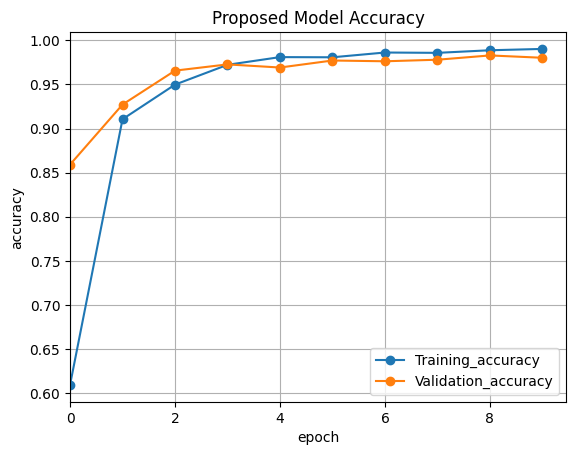

In [196]:
plt.plot(history_1.epoch, history_1.history['accuracy'], '-o', label='Training_accuracy')
plt.plot(history_1.epoch, history_1.history['val_accuracy'], '-o', label='Validation_accuracy')
plt.title('Proposed Model Accuracy')

plt.grid(True)
plt.legend()
plt.xlim(left=0)
plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.show()
plt.close()

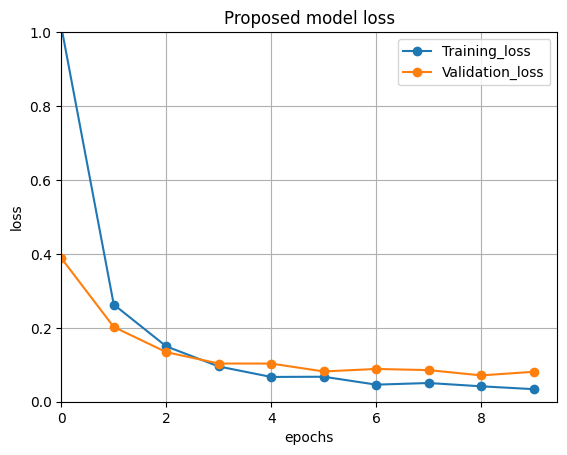

In [197]:
plt.plot(history_1.epoch, history_1.history['loss'], '-o', label='Training_loss')
plt.plot(history_1.epoch, history_1.history['val_loss'], '-o', label='Validation_loss')
plt.title('Proposed model loss')

plt.legend()
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.grid(True)
plt.xlim(left=0)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()
plt.close()

## CNN-BiLSTM MODEL

In [198]:
# %%time
X_train, X_test_unseen,  X_test, X_validate, y_train, y_test_unseen,y_test,y_validate = temp_X_train, temp_X_test_unseen,temp_X_test,temp_X_validate, temp_y_train, temp_y_test_unseen,temp_y_test,temp_y_validate


tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test_unseen = tokenizer.texts_to_sequences(X_test_unseen)
X_test = tokenizer.texts_to_sequences(X_test)
X_validate = tokenizer.texts_to_sequences(X_validate)

vocab_size = len(tokenizer.word_index) + 1
MAX_NB_WORDS = vocab_size
print(tokenizer.word_index)

max_length=max([len(i) for i in X_train])
print('Max len:', max_length)

X_train = pad_sequences(X_train, padding='post', maxlen=max_length)
X_test_unseen = pad_sequences(X_test_unseen, padding='post', maxlen=max_length)
X_test = pad_sequences(X_test, padding='post', maxlen=max_length)
X_validate = pad_sequences(X_validate, padding='post', maxlen=max_length)

y_test_unseen = to_categorical(y_test_unseen)
y_test = to_categorical(y_test)
y_train = to_categorical(y_train)
y_validate = to_categorical(y_validate)

### Cross validation ###
# X_train, y_train = temp_message, temp_label
# tokenizer_cross_val = Tokenizer()
# tokenizer_cross_val.fit_on_texts(X_train)

# X_train = tokenizer_cross_val.texts_to_sequences(X_train)

# vocab_size_cross_val = len(tokenizer_cross_val.word_index) + 1
# MAX_NB_WORDS = vocab_size_cross_val

# X_train = pad_sequences(X_train, padding='post', maxlen=max_length)
# y_train = to_categorical(y_train)


{'ค่า': 1, 'เอกสาร': 2, 'หรอ': 3, 'จ่าย': 4, 'จุด': 5, 'เทอม': 6, 'ไหม': 7, 'ถอน': 8, 'ซักไซ้': 9, 'ใบ': 10, 'วิชา': 11, 'เป็นนิสัย': 12, 'ตีพิมพ์': 13, 'หนู': 14, 'แจ้ง': 15, 'ผม': 16, 'ต้องการ': 17, 'อะ': 18, 'ขึ้นทะเบียน': 19, 'ลงทะเบียน': 20, 'เรื่อง': 21, 'ชำระ': 22, 'สวัสดี': 23, 'ประกาศนียบัตร': 24, 'ออนไลน์': 25, 'tu': 26, 'ทำ': 27, 'บัณฑิต': 28, 'นักศึกษา': 29, 'ไห': 30, 'นคะ': 31, 'กี่': 32, 'เรียน': 33, 'รายวิชา': 34, 'กด': 35, 'เงิน': 36, 'ภาคเรียน': 37, 'ตอนนี้': 38, 'ชำระเงิน': 39, 'แบบนี้': 40, 'ดีกรี': 41, 'รอ': 42, 'ป': 43, 'จดทะเบียน': 44, 'อ่ะ': 45, 'เบิก': 46, 'reg': 47, 'หน่วยกิต': 48, 'โควต้า': 49, 'ตอน': 50, 'ภาวะ': 51, 'นะคะ': 52, 'ชั่วโมง': 53, 'จบ': 54, 'transcript': 55, 'ตรวจสอบ': 56, 'ยื่น': 57, 'คณะ': 58, 'อันนี้': 59, 'เกาะ': 60, 'ซัมเมอร์': 61, 'ล่าช้า': 62, 'วันที่': 63, 'ทราบ': 64, 'มูลค่า': 65, 'ชั้น': 66, 'ศาสตร์': 67, 'หนังสือรับรอง': 68, 'w': 69, 'ค': 70, 'ฐานะ': 71, 'ท': 72, 'ติดต่อ': 73, 'รหัส': 74, 'เดินทาง': 75, 'บิล': 76, 'ทางไปรษณีย์': 77, 'กา

In [199]:
# # check the shape of each set
# print("X_train shape: {}".format(X_train.shape))
# print("y_train shape: {}".format(y_train.shape))

# # print("X_train_sub shape: {}".format(X_train_sub.shape))
# # print("y_train_sub shape: {}".format(y_train_sub.shape))

# # print("X_val shape: {}".format(X_val.shape))
# # print("y_val shape: {}".format(y_val.shape))

# print("X_test_unseen shape: {}".format(X_test_unseen.shape))
# print("y_test_unseen shape: {}".format(y_test_unseen.shape))

In [200]:
print('Train set size = {} \nTest set size = {}'.format(len(X_train),len(X_test_unseen)))

Train set size = 10559 
Test set size = 3772


In [201]:
import tensorflow as tf

def build_model_2(lr=0.0, lr_d=0.0, spatial_dr=0.0, kernel_size=3,
                  dense_units=128, dropout_ratio=0.0, num_filters=32,
                  lstm_units_1=0, lstm_units_2=0, batch_size=64, epochs=10):
    
    model_input = Input(shape=(max_length,))
    
    ######################## EMBEDDING LAYER ###############################################
    # embed MAX_NB_WORDS words into a embed_dim vector. (e.g. For fasttext, the embed__dim is 300)
    x = Embedding(MAX_NB_WORDS, embed_dim, input_length=max_length)(model_input)
            
    # dropout operation
#     x = Dropout(dropout_ratio)(x)
    x = SpatialDropout1D(spatial_dr)(x)
    
    ######################## CNN LAYER(S) ###############################################
    ## one kernel
#     conv = Conv1D(
#         filters = num_filters,
#         kernel_size=,
#         padding = "valid",
# #         kernel_initializer='he_uniform',
# #         kernel_initializer='he_normal',
#         activation = "relu",
#         strides=1
#     )(x)
    conv = Conv1D(filters=num_filters, kernel_size=kernel_size, padding="valid", activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(conv)
    
#     ## multiple kernels
#     maxpool_pool = []
#     for sz in kernel_size:
#         print("kernel ... ",sz)
#         conv = Conv1D(
#             filters = num_filters,
#             kernel_size = sz,
# #             padding = "valid",
#             padding = "same", # Use 'same' padding so outputs have the same shape as inputs.
#             kernel_initializer='he_uniform',
# #             kernel_initializer='he_normal',
#             activation = "relu",
#             strides = 1
#         )(x)
        
#         ## pooling operations
# #         conv = GlobalMaxPooling1D()(conv)
# #         conv = GlobalAveragePooling1D()(conv)
# #         conv = MaxPool1D(pool_size=(maxlen - filter_sizes[sz] + 1, 1))(conv)
# #         maxpool_pool.append(conv)

#         maxpool_pool.append(GlobalMaxPooling1D()(conv))
#         maxpool_pool.append(GlobalAveragePooling1D()(conv))

#     ## Concatenates each maxpooled result and send it to the BiLSTM layer
# #     x = concatenate()(maxpool_pool) if len(maxpool_pool) > 1 else maxpool_pool[0]
#     x = Concatenate(axis=1)(maxpool_pool)
# #     x = concatenate(maxpool_pool)  # yes or no
    
# #     x = BatchNormalization()(x) # yes or no
# #     x = Flatten()(x) # yes or no
    
    x = Dropout(dropout_ratio)(x) # yes or no
    
#     x = Dense(dense_units, activation = "relu")(x) # yes or no  
#     x = BatchNormalization()(x) # yes or no
    
    ######################## BiLSTM LAYER(S) ################################################
#     x = Bidirectional(LSTM(lstm_units, return_sequences=True))(x)
    # CuDNNLSTm can be implemented instead of LSTM, it is just implementations of LSTM that are created to run faster on GPUs
    x = Bidirectional(LSTM(lstm_units_1, return_sequences=True))(x)
    x = Bidirectional(LSTM(lstm_units_2))(x) # yes or no
#     avg_pool = GlobalAveragePooling1D()(x)  # yes or no
#     max_pool = GlobalMaxPooling1D()(x)  # yes or no
#     x = concatenate([avg_pool, max_pool])  # yes or no
    x = Dense(dense_units, activation="relu")(x)

#     x = Dropout(dropout_ratio)(x) # yes or no    

#     x = Bidirectional(LSTM(64, return_sequences=True))(x)
#     avg_pool = GlobalAveragePooling1D()(x)
#     max_pool = GlobalMaxPooling1D()(x)
#     conc = concatenate([avg_pool, max_pool])
#     conc = Dense(64, activation="relu")(conc)
#     x = Dropout(0.1)(conc)
    
    ######################## ATTENTION LAYER ################################################
    # use Attention operation, with a context/query vector, for temporal data.
#     x = AttentionWithContext()(x)
#     x = Dense(64, activation='relu')(x)  
    x = Dropout(dropout_ratio)(x)

    # The attention using Bahdanau attention.
#     attention = BahdanauAttention(lstm_units_2) # Weight Size Definition
#     context_vector, attention_weights = attention(lstm, state_h)

    # use Attention mechanism for temporal data.
#     x = Attention(max_length)(x)
#     x = GlobalMaxPooling1D()(x) # yes or no    
#     x = GlobalAveragePooling1D()(x) # yes or no    
#     x = Dropout(dropout_ratio)(x)
#     x = Dense(64, activation='relu')(x)
#     x = Dropout(dropout_ratio)(x)

    ######################## CLASSIFICATION LAYER ###########################################
    model_output = Dense(7, activation="softmax")(x)
    model = Model(model_input, model_output)
    
    ######################## COMPILING THE MODEL ##################################
    model.compile(
        loss = "categorical_crossentropy", 
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr, decay=lr_d),
        # optimizer='adam',
        metrics = [
            "accuracy",
#             "binary_accuracy",
#              'categorical_accuracy' ,
#             tf.keras.metrics.AUC(),
#             tf.keras.metrics.Precision(),
#             tf.keras.metrics.Recall()
            ]
        )
    
    ######################## MODEL SAVING/OVERFITTING MANAGEMENT ##################################
    model_path = "saved_model/best_CNN_BiLSTM_"+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + ".hdf5"
    check_point = ModelCheckpoint(model_path, monitor="val_loss", verbose=1, save_best_only=True, mode="min")
    early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=3, verbose=1)
    
    # Display a summary of the models structure
    print(model.summary())
    print("#"*80)
    tf.keras.utils.plot_model(model, to_file="cnn_BiLSTM_architecture_"+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + ".png", show_shapes=True)
    
    ######################## TRAINING THE MODEL ##################################
    start_time = time()
    history = model.fit(
        X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_validate, y_validate),
        callbacks=[check_point,early_stop])
    train_time = time() - start_time
    print(train_time)

#     model = load_model(model_path)
    model = load_model(model_path, custom_objects=create_custom_objects())
    
    ######################## EVALUATING THE MODEL ##################################  
    model.evaluate(X_test_unseen, y_test_unseen) # or model.predict
    
    return model, history, train_time

In [202]:
# Train proposed model
model_2, history_5, train_time = build_model_2(lr=learning_rate, lr_d=learning_decay, spatial_dr=spa_dropout_ratio, kernel_size=kernel_size,
                                            dense_units=dense_units, dropout_ratio=dropout_ratio, num_filters=num_filters, lstm_units_1=lstm_units_1,
                                            lstm_units_2=lstm_units_2, batch_size=batch_size, epochs=epochs
                                           )

Model: "model_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_56 (InputLayer)       [(None, 15)]              0         
                                                                 
 embedding_44 (Embedding)    (None, 15, 300)           576600    
                                                                 
 spatial_dropout1d_77 (Spat  (None, 15, 300)           0         
 ialDropout1D)                                                   
                                                                 
 conv1d_66 (Conv1D)          (None, 13, 50)            45050     
                                                                 
 max_pooling1d_66 (MaxPooli  (None, 6, 50)             0         
 ng1D)                                                           
                                                                 
 dropout_132 (Dropout)       (None, 6, 50)             0  

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


162/165 [============================>.] - ETA: 0s - loss: 0.2711 - accuracy: 0.9149
Epoch 2: val_loss improved from 0.42258 to 0.18698, saving model to saved_model/best_CNN_BiLSTM_20240210_16-22-56.hdf5
165/165 [==============================] - 2s 10ms/step - loss: 0.2699 - accuracy: 0.9154 - val_loss: 0.1870 - val_accuracy: 0.9479
Epoch 3/10
161/165 [============================>.] - ETA: 0s - loss: 0.1243 - accuracy: 0.9622
Epoch 3: val_loss improved from 0.18698 to 0.11830, saving model to saved_model/best_CNN_BiLSTM_20240210_16-22-56.hdf5
165/165 [==============================] - 2s 11ms/step - loss: 0.1239 - accuracy: 0.9622 - val_loss: 0.1183 - val_accuracy: 0.9660
Epoch 4/10
161/165 [============================>.] - ETA: 0s - loss: 0.0692 - accuracy: 0.9808
Epoch 4: val_loss improved from 0.11830 to 0.10152, saving model to saved_model/best_CNN_BiLSTM_20240210_16-22-56.hdf5
165/165 [==============================] - 2s 10ms/step - loss: 0.0700 - accuracy: 0.9804 - val_loss: 

In [203]:
# Test 15%
predicted = model_2.predict(X_test)

predicted = np.argmax(predicted, axis=1)
y_test = np.argmax(y_test,axis=1)

# report = classification_report(y_test_unseen, predicted, output_dict=True)
report = classification_report(y_test, predicted, digits=4)
print(report)


# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, predicted)
print('Testing Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, predicted,average='weighted')
print('Testing Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, predicted,average='weighted')
print('Testing Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, predicted,average='weighted')
print('Testing F1 score: %f' % f1)


71/71 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0     0.9867    0.9795    0.9831       683
           1     0.9845    0.9845    0.9845       516
           2     0.9873    0.9286    0.9571        84
           3     0.9721    0.9876    0.9798       565
           4     0.9589    0.9859    0.9722        71
           5     0.9882    0.9655    0.9767        87
           6     0.9768    0.9806    0.9787       258

    accuracy                         0.9806      2264
   macro avg     0.9792    0.9732    0.9760      2264
weighted avg     0.9807    0.9806    0.9805      2264

Testing Accuracy: 0.980565
Testing Precision: 0.980655
Testing Recall: 0.980565
Testing F1 score: 0.980546


In [204]:
df_results.loc['CNN-BiLSTM Test 15%'] = [f1, precision, recall, accuracy, train_time]
df_results

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM Test 15%,0.983170,0.983289,0.983216,0.983216,20.757635
Att-Based CNN-BiLSTM Validate 15%,0.982764,0.982835,0.982774,0.982774,20.757635
Att-Based CNN-BiLSTM Test unseen 20%,0.982501,0.982676,0.982503,0.982503,20.757635
CNN-BiLSTM Test 15%,0.980546,0.980655,0.980565,0.980565,19.530745


In [205]:
# Validate 15%
predicted_val = model_2.predict(X_validate)

predicted_val = np.argmax(predicted_val, axis=1)
y_validate = np.argmax(y_validate,axis=1)

report = classification_report(y_validate, predicted_val, digits=4)
print(report)

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_validate, predicted_val)
print('Testing Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_validate, predicted_val,average='weighted')
print('Testing Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_validate, predicted_val,average='weighted')
print('Testing Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_validate, predicted_val,average='weighted')
print('Testing F1 score: %f' % f1)

71/71 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0     0.9940    0.9751    0.9845       682
           1     0.9844    0.9806    0.9825       516
           2     0.9756    0.9524    0.9639        84
           3     0.9621    0.9894    0.9756       565
           4     0.9726    1.0000    0.9861        71
           5     0.9773    0.9773    0.9773        88
           6     0.9767    0.9729    0.9748       258

    accuracy                         0.9797      2264
   macro avg     0.9775    0.9782    0.9778      2264
weighted avg     0.9799    0.9797    0.9797      2264

Testing Accuracy: 0.979682
Testing Precision: 0.979894
Testing Recall: 0.979682
Testing F1 score: 0.979701


In [206]:

df_results.loc['CNN-BiLSTM Validate 15%'] = [f1, precision, recall, accuracy, train_time]
df_results

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM Test 15%,0.983170,0.983289,0.983216,0.983216,20.757635
Att-Based CNN-BiLSTM Validate 15%,0.982764,0.982835,0.982774,0.982774,20.757635
Att-Based CNN-BiLSTM Test unseen 20%,0.982501,0.982676,0.982503,0.982503,20.757635
CNN-BiLSTM Test 15%,0.980546,0.980655,0.980565,0.980565,19.530745
CNN-BiLSTM Validate 15%,0.979701,0.979894,0.979682,0.979682,19.530745


In [207]:
# Test unseen 15%

predicted = model_2.predict(X_test_unseen)

predicted = np.argmax(predicted, axis=1)
y_test_unseen = np.argmax(y_test_unseen,axis=1)

# report = classification_report(y_test_unseen, predicted, output_dict=True)
report = classification_report(y_test_unseen, predicted, digits=4)
print(report)

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test_unseen, predicted)
print('Testing Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test_unseen, predicted,average='weighted')
print('Testing Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test_unseen, predicted,average='weighted')
print('Testing Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test_unseen, predicted,average='weighted')
print('Testing F1 score: %f' % f1)

118/118 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0     0.9912    0.9859    0.9885      1137
           1     0.9847    0.9710    0.9778       861
           2     0.9855    0.9714    0.9784       140
           3     0.9719    0.9926    0.9821       941
           4     0.9667    0.9831    0.9748       118
           5     0.9929    0.9521    0.9720       146
           6     0.9838    0.9930    0.9884       429

    accuracy                         0.9830      3772
   macro avg     0.9824    0.9784    0.9803      3772
weighted avg     0.9831    0.9830    0.9830      3772

Testing Accuracy: 0.983033
Testing Precision: 0.983135
Testing Recall: 0.983033
Testing F1 score: 0.983021


In [208]:

# append the results
df_results.loc['CNN-BiLSTM Test unseen 20%'] = [f1, precision, recall, accuracy, train_time]
df_results

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM Test 15%,0.983170,0.983289,0.983216,0.983216,20.757635
Att-Based CNN-BiLSTM Validate 15%,0.982764,0.982835,0.982774,0.982774,20.757635
Att-Based CNN-BiLSTM Test unseen 20%,0.982501,0.982676,0.982503,0.982503,20.757635
CNN-BiLSTM Test 15%,0.980546,0.980655,0.980565,0.980565,19.530745
CNN-BiLSTM Validate 15%,0.979701,0.979894,0.979682,0.979682,19.530745
CNN-BiLSTM Test unseen 20%,0.983021,0.983135,0.983033,0.983033,19.530745


In [209]:
# %%time
X_train, X_test_unseen,  X_test, X_validate, y_train, y_test_unseen,y_test,y_validate = temp_X_train, temp_X_test_unseen,temp_X_test,temp_X_validate, temp_y_train, temp_y_test_unseen,temp_y_test,temp_y_validate


tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test_unseen = tokenizer.texts_to_sequences(X_test_unseen)
X_test = tokenizer.texts_to_sequences(X_test)
X_validate = tokenizer.texts_to_sequences(X_validate)

vocab_size = len(tokenizer.word_index) + 1
MAX_NB_WORDS = vocab_size
print(tokenizer.word_index)

max_length=max([len(i) for i in X_train])
print('Max len:', max_length)

X_train = pad_sequences(X_train, padding='post', maxlen=max_length)
X_test_unseen = pad_sequences(X_test_unseen, padding='post', maxlen=max_length)
X_test = pad_sequences(X_test, padding='post', maxlen=max_length)
X_validate = pad_sequences(X_validate, padding='post', maxlen=max_length)

y_test_unseen = to_categorical(y_test_unseen)
y_test = to_categorical(y_test)
y_train = to_categorical(y_train)
y_validate = to_categorical(y_validate)

### Cross validation ###
# X_train, y_train = temp_message, temp_label
# tokenizer_cross_val = Tokenizer()
# tokenizer_cross_val.fit_on_texts(X_train)

# X_train = tokenizer_cross_val.texts_to_sequences(X_train)

# vocab_size_cross_val = len(tokenizer_cross_val.word_index) + 1
# MAX_NB_WORDS = vocab_size_cross_val

# X_train = pad_sequences(X_train, padding='post', maxlen=max_length)
# y_train = to_categorical(y_train)


{'ค่า': 1, 'เอกสาร': 2, 'หรอ': 3, 'จ่าย': 4, 'จุด': 5, 'เทอม': 6, 'ไหม': 7, 'ถอน': 8, 'ซักไซ้': 9, 'ใบ': 10, 'วิชา': 11, 'เป็นนิสัย': 12, 'ตีพิมพ์': 13, 'หนู': 14, 'แจ้ง': 15, 'ผม': 16, 'ต้องการ': 17, 'อะ': 18, 'ขึ้นทะเบียน': 19, 'ลงทะเบียน': 20, 'เรื่อง': 21, 'ชำระ': 22, 'สวัสดี': 23, 'ประกาศนียบัตร': 24, 'ออนไลน์': 25, 'tu': 26, 'ทำ': 27, 'บัณฑิต': 28, 'นักศึกษา': 29, 'ไห': 30, 'นคะ': 31, 'กี่': 32, 'เรียน': 33, 'รายวิชา': 34, 'กด': 35, 'เงิน': 36, 'ภาคเรียน': 37, 'ตอนนี้': 38, 'ชำระเงิน': 39, 'แบบนี้': 40, 'ดีกรี': 41, 'รอ': 42, 'ป': 43, 'จดทะเบียน': 44, 'อ่ะ': 45, 'เบิก': 46, 'reg': 47, 'หน่วยกิต': 48, 'โควต้า': 49, 'ตอน': 50, 'ภาวะ': 51, 'นะคะ': 52, 'ชั่วโมง': 53, 'จบ': 54, 'transcript': 55, 'ตรวจสอบ': 56, 'ยื่น': 57, 'คณะ': 58, 'อันนี้': 59, 'เกาะ': 60, 'ซัมเมอร์': 61, 'ล่าช้า': 62, 'วันที่': 63, 'ทราบ': 64, 'มูลค่า': 65, 'ชั้น': 66, 'ศาสตร์': 67, 'หนังสือรับรอง': 68, 'w': 69, 'ค': 70, 'ฐานะ': 71, 'ท': 72, 'ติดต่อ': 73, 'รหัส': 74, 'เดินทาง': 75, 'บิล': 76, 'ทางไปรษณีย์': 77, 'กา

In [210]:

# Number of folds
num_folds = 10

# Create a StratifiedKFold object
kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

accuracy_scores_cnn_bilstm = []
precision_scores_cnn_bilstm = []
f1_scores_cnn_bilstm = []
recall_scores_cnn_bilstm = []

X, y_encoded = X_train, y_train
total_train_time = 0  # Initialize total training time

# Perform cross-validation
fold_var = 1
for i, (train_index, test_index) in enumerate(kf.split(X, y_encoded.argmax(1))):
    fold_var +=1
    print("------ Fold ----------", fold_var)
    
    X_train, X_val = X[train_index], X[test_index]
    y_train, y_val = y_encoded[train_index], y_encoded[test_index]

    model_input = Input(shape=(max_length,))
    
    ######################## EMBEDDING LAYER ###############################################
    # embed MAX_NB_WORDS words into a embed_dim vector. (e.g. For fasttext, the embed__dim is 300)
    x = Embedding(MAX_NB_WORDS, embed_dim, input_length=max_length)(model_input)
            
    # dropout operation
#     x = Dropout(dropout_ratio)(x)
    x = SpatialDropout1D(spa_dropout_ratio)(x)
    
    ######################## CNN LAYER(S) ###############################################
    ## one kernel
#     conv = Conv1D(
#         filters = num_filters,
#         kernel_size=,
#         padding = "valid",
# #         kernel_initializer='he_uniform',
# #         kernel_initializer='he_normal',
#         activation = "relu",
#         strides=1
#     )(x)
    conv = Conv1D(filters=num_filters, kernel_size=kernel_size, padding="valid", activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(conv)
    
#     ## multiple kernels
#     maxpool_pool = []
#     for sz in kernel_size:
#         print("kernel ... ",sz)
#         conv = Conv1D(
#             filters = num_filters,
#             kernel_size = sz,
# #             padding = "valid",
#             padding = "same", # Use 'same' padding so outputs have the same shape as inputs.
#             kernel_initializer='he_uniform',
# #             kernel_initializer='he_normal',
#             activation = "relu",
#             strides = 1
#         )(x)
        
#         ## pooling operations
# #         conv = GlobalMaxPooling1D()(conv)
# #         conv = GlobalAveragePooling1D()(conv)
# #         conv = MaxPool1D(pool_size=(maxlen - filter_sizes[sz] + 1, 1))(conv)
# #         maxpool_pool.append(conv)

#         maxpool_pool.append(GlobalMaxPooling1D()(conv))
#         maxpool_pool.append(GlobalAveragePooling1D()(conv))

#     ## Concatenates each maxpooled result and send it to the BiLSTM layer
# #     x = concatenate()(maxpool_pool) if len(maxpool_pool) > 1 else maxpool_pool[0]
#     x = Concatenate(axis=1)(maxpool_pool)
# #     x = concatenate(maxpool_pool)  # yes or no
    
# #     x = BatchNormalization()(x) # yes or no
# #     x = Flatten()(x) # yes or no
    
    x = Dropout(dropout_ratio)(x) # yes or no
    
#     x = Dense(dense_units, activation = "relu")(x) # yes or no  
#     x = BatchNormalization()(x) # yes or no
    
    ######################## BiLSTM LAYER(S) ################################################
#     x = Bidirectional(LSTM(lstm_units, return_sequences=True))(x)
    # CuDNNLSTm can be implemented instead of LSTM, it is just implementations of LSTM that are created to run faster on GPUs
    x = Bidirectional(LSTM(lstm_units_1, return_sequences=True))(x)
    x = Bidirectional(LSTM(lstm_units_2))(x) # yes or no
#     avg_pool = GlobalAveragePooling1D()(x)  # yes or no
#     max_pool = GlobalMaxPooling1D()(x)  # yes or no
#     x = concatenate([avg_pool, max_pool])  # yes or no
    x = Dense(dense_units, activation="relu")(x)

#     x = Dropout(dropout_ratio)(x) # yes or no    

#     x = Bidirectional(LSTM(64, return_sequences=True))(x)
#     avg_pool = GlobalAveragePooling1D()(x)
#     max_pool = GlobalMaxPooling1D()(x)
#     conc = concatenate([avg_pool, max_pool])
#     conc = Dense(64, activation="relu")(conc)
#     x = Dropout(0.1)(conc)
    
    ######################## ATTENTION LAYER ################################################
    # use Attention operation, with a context/query vector, for temporal data.
#     x = AttentionWithContext()(x)
#     x = Dense(64, activation='relu')(x)  
    x = Dropout(dropout_ratio)(x)

    # The attention using Bahdanau attention.
#     attention = BahdanauAttention(lstm_units_2) # Weight Size Definition
#     context_vector, attention_weights = attention(lstm, state_h)

    # use Attention mechanism for temporal data.
#     x = Attention(max_length)(x)
#     x = GlobalMaxPooling1D()(x) # yes or no    
#     x = GlobalAveragePooling1D()(x) # yes or no    
#     x = Dropout(dropout_ratio)(x)
#     x = Dense(64, activation='relu')(x)
#     x = Dropout(dropout_ratio)(x)

    ######################## CLASSIFICATION LAYER ###########################################
    model_output = Dense(7, activation="softmax")(x)
    cnn_bisltm_model = Model(model_input, model_output)
    
    ######################## COMPILING THE MODEL ##################################
    cnn_bisltm_model.compile(
        loss = "categorical_crossentropy", 
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate, decay=learning_decay),
        # optimizer='adam',
        metrics = [
            "accuracy",
#             "binary_accuracy",
#              'categorical_accuracy' ,
#             tf.keras.metrics.AUC(),
#             tf.keras.metrics.Precision(),
#             tf.keras.metrics.Recall()
            ]
        )
    
    ######################## MODEL SAVING/OVERFITTING MANAGEMENT #################################
    check_point = ModelCheckpoint(cnn_bilstm_cross_validate_model_path, monitor="val_loss", verbose=1, save_best_only=True, mode="min")
    early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=3, verbose=1)
    
    # Display a summary of the models structure
    print(cnn_bisltm_model.summary())
    print("#"*80)
    # tf.keras.utils.plot_model(cnn_bisltm_model, to_file="cnn_BiLSTM_architecture_"+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + ".png", show_shapes=True)
    
    ######################## TRAINING THE MODEL ##################################
    start_time = time()
    history = cnn_bisltm_model.fit(
        X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_val, y_val),
        callbacks=[check_point,early_stop])
    total_train_time += train_time
    
    y_pred=np.argmax(cnn_bisltm_model.predict(X_val), axis=-1)
    y_true_validation_test = np.argmax(y_val,axis = 1)
    
    accuracy_scores_cnn_bilstm.append(accuracy_score(y_true_validation_test, y_pred))
    precision_scores_cnn_bilstm.append(precision_score(y_true_validation_test, y_pred, average='weighted'))
    f1_scores_cnn_bilstm.append(f1_score(y_true_validation_test, y_pred, average='weighted'))
    recall_scores_cnn_bilstm.append(f1_score(y_true_validation_test, y_pred, average='weighted'))



------ Fold ---------- 2
Model: "model_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_57 (InputLayer)       [(None, 15)]              0         
                                                                 
 embedding_45 (Embedding)    (None, 15, 300)           576600    
                                                                 
 spatial_dropout1d_78 (Spat  (None, 15, 300)           0         
 ialDropout1D)                                                   
                                                                 
 conv1d_67 (Conv1D)          (None, 13, 50)            45050     
                                                                 
 max_pooling1d_67 (MaxPooli  (None, 6, 50)             0         
 ng1D)                                                           
                                                                 
 dropout_134 (Dropout)       (Non

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


144/149 [===========================>..] - ETA: 0s - loss: 0.3191 - accuracy: 0.9048
Epoch 2: val_loss improved from 0.50740 to 0.21879, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
149/149 [==============================] - 2s 10ms/step - loss: 0.3180 - accuracy: 0.9048 - val_loss: 0.2188 - val_accuracy: 0.9347
Epoch 3/10
148/149 [============================>.] - ETA: 0s - loss: 0.1518 - accuracy: 0.9565
Epoch 3: val_loss improved from 0.21879 to 0.14093, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
149/149 [==============================] - 1s 10ms/step - loss: 0.1514 - accuracy: 0.9566 - val_loss: 0.1409 - val_accuracy: 0.9574
Epoch 4/10
147/149 [============================>.] - ETA: 0s - loss: 0.0997 - accuracy: 0.9711
Epoch 4: val_loss improved from 0.14093 to 0.08901, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
149/149 [==============================] - 2s 10ms/step - loss: 0.0995 - accuracy: 0.9712 - val_loss: 0.0

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


148/149 [============================>.] - ETA: 0s - loss: 0.2414 - accuracy: 0.9267
Epoch 2: val_loss improved from 0.37048 to 0.21581, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
149/149 [==============================] - 2s 11ms/step - loss: 0.2410 - accuracy: 0.9270 - val_loss: 0.2158 - val_accuracy: 0.9489
Epoch 3/10
149/149 [==============================] - ETA: 0s - loss: 0.1185 - accuracy: 0.9673
Epoch 3: val_loss improved from 0.21581 to 0.15850, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
149/149 [==============================] - 2s 10ms/step - loss: 0.1185 - accuracy: 0.9673 - val_loss: 0.1585 - val_accuracy: 0.9574
Epoch 4/10
147/149 [============================>.] - ETA: 0s - loss: 0.0811 - accuracy: 0.9775
Epoch 4: val_loss improved from 0.15850 to 0.13715, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
149/149 [==============================] - 1s 10ms/step - loss: 0.0812 - accuracy: 0.9774 - val_loss: 0.1

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


147/149 [============================>.] - ETA: 0s - loss: 0.2383 - accuracy: 0.9318
Epoch 2: val_loss improved from 0.37196 to 0.16348, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
149/149 [==============================] - 2s 10ms/step - loss: 0.2379 - accuracy: 0.9317 - val_loss: 0.1635 - val_accuracy: 0.9517
Epoch 3/10
145/149 [============================>.] - ETA: 0s - loss: 0.1072 - accuracy: 0.9709
Epoch 3: val_loss improved from 0.16348 to 0.12493, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
149/149 [==============================] - 1s 10ms/step - loss: 0.1082 - accuracy: 0.9704 - val_loss: 0.1249 - val_accuracy: 0.9621
Epoch 4/10
148/149 [============================>.] - ETA: 0s - loss: 0.0744 - accuracy: 0.9776
Epoch 4: val_loss improved from 0.12493 to 0.11030, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
149/149 [==============================] - 2s 10ms/step - loss: 0.0742 - accuracy: 0.9776 - val_loss: 0.1

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


145/149 [============================>.] - ETA: 0s - loss: 0.3181 - accuracy: 0.8985
Epoch 2: val_loss improved from 0.44276 to 0.17861, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
149/149 [==============================] - 1s 10ms/step - loss: 0.3148 - accuracy: 0.9000 - val_loss: 0.1786 - val_accuracy: 0.9441
Epoch 3/10
149/149 [==============================] - ETA: 0s - loss: 0.1531 - accuracy: 0.9575
Epoch 3: val_loss improved from 0.17861 to 0.14942, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
149/149 [==============================] - 1s 10ms/step - loss: 0.1531 - accuracy: 0.9575 - val_loss: 0.1494 - val_accuracy: 0.9517
Epoch 4/10
146/149 [============================>.] - ETA: 0s - loss: 0.0964 - accuracy: 0.9750
Epoch 4: val_loss improved from 0.14942 to 0.07587, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
149/149 [==============================] - 1s 10ms/step - loss: 0.0963 - accuracy: 0.9750 - val_loss: 0.0

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


145/149 [============================>.] - ETA: 0s - loss: 0.2549 - accuracy: 0.9209
Epoch 2: val_loss improved from 0.38205 to 0.17283, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
149/149 [==============================] - 1s 10ms/step - loss: 0.2510 - accuracy: 0.9223 - val_loss: 0.1728 - val_accuracy: 0.9527
Epoch 3/10
148/149 [============================>.] - ETA: 0s - loss: 0.1193 - accuracy: 0.9671
Epoch 3: val_loss improved from 0.17283 to 0.12251, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
149/149 [==============================] - 1s 9ms/step - loss: 0.1189 - accuracy: 0.9672 - val_loss: 0.1225 - val_accuracy: 0.9640
Epoch 4/10
148/149 [============================>.] - ETA: 0s - loss: 0.0919 - accuracy: 0.9730
Epoch 4: val_loss improved from 0.12251 to 0.11168, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
149/149 [==============================] - 1s 10ms/step - loss: 0.0918 - accuracy: 0.9731 - val_loss: 0.11

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


147/149 [============================>.] - ETA: 0s - loss: 0.2722 - accuracy: 0.9134
Epoch 2: val_loss improved from 0.40509 to 0.17708, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
149/149 [==============================] - 1s 10ms/step - loss: 0.2708 - accuracy: 0.9140 - val_loss: 0.1771 - val_accuracy: 0.9545
Epoch 3/10
146/149 [============================>.] - ETA: 0s - loss: 0.1339 - accuracy: 0.9617
Epoch 3: val_loss improved from 0.17708 to 0.11827, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
149/149 [==============================] - 1s 10ms/step - loss: 0.1329 - accuracy: 0.9621 - val_loss: 0.1183 - val_accuracy: 0.9659
Epoch 4/10
146/149 [============================>.] - ETA: 0s - loss: 0.0934 - accuracy: 0.9728
Epoch 4: val_loss improved from 0.11827 to 0.09285, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
149/149 [==============================] - 1s 10ms/step - loss: 0.0929 - accuracy: 0.9729 - val_loss: 0.0

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


148/149 [============================>.] - ETA: 0s - loss: 0.2632 - accuracy: 0.9162
Epoch 2: val_loss improved from 0.37136 to 0.15701, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
149/149 [==============================] - 1s 10ms/step - loss: 0.2626 - accuracy: 0.9163 - val_loss: 0.1570 - val_accuracy: 0.9555
Epoch 3/10
148/149 [============================>.] - ETA: 0s - loss: 0.1191 - accuracy: 0.9660
Epoch 3: val_loss improved from 0.15701 to 0.10892, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
149/149 [==============================] - 1s 10ms/step - loss: 0.1193 - accuracy: 0.9658 - val_loss: 0.1089 - val_accuracy: 0.9631
Epoch 4/10
148/149 [============================>.] - ETA: 0s - loss: 0.0777 - accuracy: 0.9776
Epoch 4: val_loss improved from 0.10892 to 0.09716, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
149/149 [==============================] - 1s 10ms/step - loss: 0.0776 - accuracy: 0.9776 - val_loss: 0.0

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


149/149 [==============================] - ETA: 0s - loss: 0.2333 - accuracy: 0.9290
Epoch 2: val_loss improved from 0.33127 to 0.16304, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
149/149 [==============================] - 1s 10ms/step - loss: 0.2333 - accuracy: 0.9290 - val_loss: 0.1630 - val_accuracy: 0.9527
Epoch 3/10
145/149 [============================>.] - ETA: 0s - loss: 0.1154 - accuracy: 0.9677
Epoch 3: val_loss improved from 0.16304 to 0.12319, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
149/149 [==============================] - 1s 10ms/step - loss: 0.1149 - accuracy: 0.9678 - val_loss: 0.1232 - val_accuracy: 0.9640
Epoch 4/10
144/149 [===========================>..] - ETA: 0s - loss: 0.0743 - accuracy: 0.9783
Epoch 4: val_loss improved from 0.12319 to 0.10088, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
149/149 [==============================] - 1s 10ms/step - loss: 0.0743 - accuracy: 0.9783 - val_loss: 0.1

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


144/149 [===========================>..] - ETA: 0s - loss: 0.2279 - accuracy: 0.9299
Epoch 2: val_loss improved from 0.39434 to 0.18453, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
149/149 [==============================] - 1s 10ms/step - loss: 0.2246 - accuracy: 0.9310 - val_loss: 0.1845 - val_accuracy: 0.9451
Epoch 3/10
145/149 [============================>.] - ETA: 0s - loss: 0.1140 - accuracy: 0.9667
Epoch 3: val_loss improved from 0.18453 to 0.15613, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
149/149 [==============================] - 1s 10ms/step - loss: 0.1136 - accuracy: 0.9669 - val_loss: 0.1561 - val_accuracy: 0.9470
Epoch 4/10
145/149 [============================>.] - ETA: 0s - loss: 0.0826 - accuracy: 0.9758
Epoch 4: val_loss improved from 0.15613 to 0.12771, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
149/149 [==============================] - 1s 9ms/step - loss: 0.0824 - accuracy: 0.9756 - val_loss: 0.12

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


144/149 [===========================>..] - ETA: 0s - loss: 0.2379 - accuracy: 0.9319
Epoch 2: val_loss improved from 0.35682 to 0.18913, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
149/149 [==============================] - 1s 9ms/step - loss: 0.2342 - accuracy: 0.9329 - val_loss: 0.1891 - val_accuracy: 0.9488
Epoch 3/10
146/149 [============================>.] - ETA: 0s - loss: 0.1144 - accuracy: 0.9689
Epoch 3: val_loss improved from 0.18913 to 0.14005, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
149/149 [==============================] - 1s 10ms/step - loss: 0.1148 - accuracy: 0.9689 - val_loss: 0.1400 - val_accuracy: 0.9573
Epoch 4/10
144/149 [===========================>..] - ETA: 0s - loss: 0.0824 - accuracy: 0.9766
Epoch 4: val_loss improved from 0.14005 to 0.11529, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
149/149 [==============================] - 1s 10ms/step - loss: 0.0809 - accuracy: 0.9770 - val_loss: 0.11

In [211]:
accuracy_avg_cnn_bilstm = sum(accuracy_scores_cnn_bilstm) / len(accuracy_scores_cnn_bilstm)
precision_avg_cnn_bilstm = sum(precision_scores_cnn_bilstm) / len(precision_scores_cnn_bilstm)
recall_avg_cnn_bilstm = sum(recall_scores_cnn_bilstm) / len(recall_scores_cnn_bilstm)
f1_avg_cnn_bilstm = sum(f1_scores_cnn_bilstm) / len(f1_scores_cnn_bilstm)

results_df = pd.DataFrame({
    'Fold': list(range(1, num_folds+1)),
    'Accuracy': accuracy_scores_cnn_bilstm,
    'Precision': precision_scores_cnn_bilstm,
    'Recall': recall_scores_cnn_bilstm,
    'F1 Score': f1_scores_cnn_bilstm
 
})
results_df.loc[num_folds] = ['Avg.', accuracy_avg_cnn_bilstm,precision_avg_cnn_bilstm,recall_avg_cnn_bilstm,f1_avg_cnn_bilstm]
print(results_df.to_markdown(index=False))

| Fold   |   Accuracy |   Precision |   Recall |   F1 Score |
|:-------|-----------:|------------:|---------:|-----------:|
| 1      |   0.985795 |    0.985995 | 0.985755 |   0.985755 |
| 2      |   0.974432 |    0.974668 | 0.974386 |   0.974386 |
| 3      |   0.974432 |    0.974902 | 0.974388 |   0.974388 |
| 4      |   0.985795 |    0.985918 | 0.98579  |   0.98579  |
| 5      |   0.966856 |    0.967107 | 0.966772 |   0.966772 |
| 6      |   0.973485 |    0.974031 | 0.973282 |   0.973282 |
| 7      |   0.982955 |    0.983201 | 0.982977 |   0.982977 |
| 8      |   0.979167 |    0.97952  | 0.979208 |   0.979208 |
| 9      |   0.967803 |    0.968111 | 0.967754 |   0.967754 |
| 10     |   0.966825 |    0.967882 | 0.966739 |   0.966739 |
| Avg.   |   0.975754 |    0.976133 | 0.975705 |   0.975705 |


In [212]:
df_results_cross_val.loc['CNN-BiLSTM avg cross validation data train 80%'] = [f1_avg_cnn_bilstm, precision_avg_cnn_bilstm, recall_avg_cnn_bilstm, accuracy_avg_cnn_bilstm, total_train_time]
df_results_cross_val

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM avg cross validation data test 80%,0.973766,0.974320,0.973766,0.973767,207.576349
Att-Based CNN-BiLSTM avg cross validation data test 20%,0.981420,0.981496,0.981442,0.981442,20.757635
CNN-BiLSTM avg cross validation data train 80%,0.975705,0.976133,0.975705,0.975754,195.307448


In [213]:
# Test cross validation 20%
model_bilstm_cross_validate = load_model(cnn_bilstm_cross_validate_model_path)
predicted = model_bilstm_cross_validate.predict(X_test_unseen)

predicted = np.argmax(predicted, axis=1)
y_test_unseen = np.argmax(y_test_unseen,axis=1)

# report = classification_report(y_test_unseen, predicted, output_dict=True)
report = classification_report(y_test_unseen, predicted, digits=4)
# print(report)


# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test_unseen, predicted)
print('Testing Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test_unseen, predicted,average='weighted')
print('Testing Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test_unseen, predicted,average='weighted')
print('Testing Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test_unseen, predicted,average='weighted')
print('Testing F1 score: %f' % f1)

118/118 [==============================] - 1s 1ms/step
Testing Accuracy: 0.974549
Testing Precision: 0.974580
Testing Recall: 0.974549
Testing F1 score: 0.974537


In [214]:
df_results_cross_val.loc['CNN-BiLSTM avg cross validation data test 20%'] = [f1, precision, recall, accuracy, train_time]
df_results_cross_val

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM avg cross validation data test 80%,0.973766,0.974320,0.973766,0.973767,207.576349
Att-Based CNN-BiLSTM avg cross validation data test 20%,0.981420,0.981496,0.981442,0.981442,20.757635
CNN-BiLSTM avg cross validation data train 80%,0.975705,0.976133,0.975705,0.975754,195.307448
CNN-BiLSTM avg cross validation data test 20%,0.974537,0.974580,0.974549,0.974549,19.530745


### Plotting the results

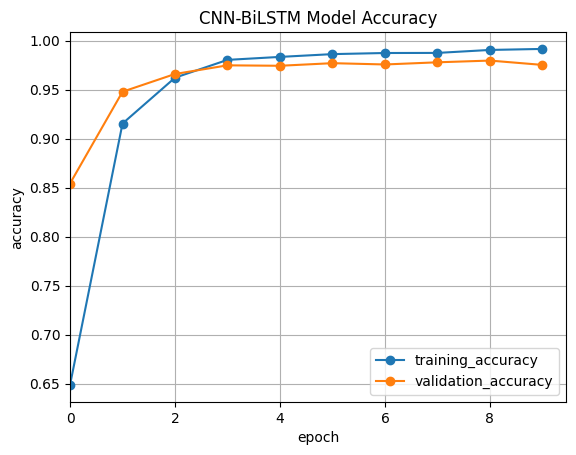

In [215]:
# summarize history for accuracy
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()


plt.plot(history_5.epoch, history_5.history['accuracy'], '-o', label='training_accuracy')
plt.plot(history_5.epoch, history_5.history['val_accuracy'], '-o', label='validation_accuracy')
plt.title('CNN-BiLSTM Model Accuracy')

plt.grid(True)
plt.legend()
plt.xlim(left=0)
plt.xlabel('epoch')
plt.ylabel('accuracy')
# plt.savefig('CNN-BiLSTM_accuracy_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.png', dpi=600, format='png', bbox_inches='tight')
# plt.savefig('CNN-BiLSTM_accuracy_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.pdf', dpi=600, format='pdf', bbox_inches='tight')
plt.show()
plt.close()

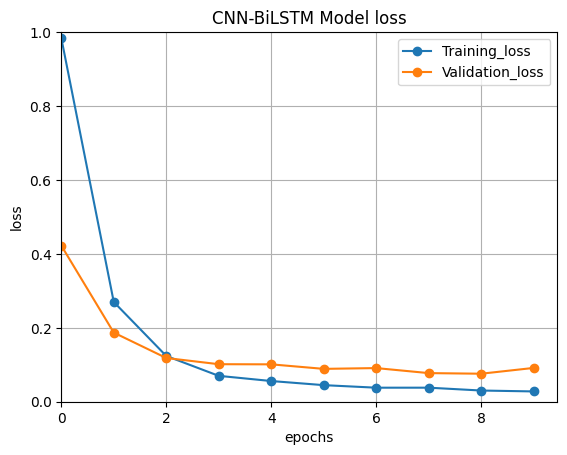

In [216]:
# summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

plt.plot(history_5.epoch, history_5.history['loss'], '-o', label='Training_loss')
plt.plot(history_5.epoch, history_5.history['val_loss'], '-o', label='Validation_loss')
plt.title('CNN-BiLSTM Model loss')

plt.legend()
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.grid(True)
plt.xlim(left=0)
plt.xlabel('epochs')
plt.ylabel('loss')
# plt.savefig('CNN-BiLSTM_loss_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.png', dpi=600, format='png', bbox_inches='tight')
# plt.savefig('CNN-BiLSTM_loss_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.pdf', dpi=600, format='pdf', bbox_inches='tight')
plt.show()
plt.close()

# BASELINES MODELS

## 1D CNN MODEL

In [217]:
# %%time
X_train, X_test_unseen,  X_test, X_validate, y_train, y_test_unseen,y_test,y_validate = temp_X_train, temp_X_test_unseen,temp_X_test,temp_X_validate, temp_y_train, temp_y_test_unseen,temp_y_test,temp_y_validate


tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test_unseen = tokenizer.texts_to_sequences(X_test_unseen)
X_test = tokenizer.texts_to_sequences(X_test)
X_validate = tokenizer.texts_to_sequences(X_validate)

vocab_size = len(tokenizer.word_index) + 1
MAX_NB_WORDS = vocab_size
print(tokenizer.word_index)

max_length=max([len(i) for i in X_train])
print('Max len:', max_length)

X_train = pad_sequences(X_train, padding='post', maxlen=max_length)
X_test_unseen = pad_sequences(X_test_unseen, padding='post', maxlen=max_length)
X_test = pad_sequences(X_test, padding='post', maxlen=max_length)
X_validate = pad_sequences(X_validate, padding='post', maxlen=max_length)

y_test_unseen = to_categorical(y_test_unseen)
y_test = to_categorical(y_test)
y_train = to_categorical(y_train)
y_validate = to_categorical(y_validate)

# ### Cross validation ###
# X_train, y_train = temp_message, temp_label
# tokenizer_cross_val = Tokenizer()
# tokenizer_cross_val.fit_on_texts(X_train)

# X_train = tokenizer_cross_val.texts_to_sequences(X_train)

# vocab_size_cross_val = len(tokenizer_cross_val.word_index) + 1
# MAX_NB_WORDS = vocab_size_cross_val

# X_train = pad_sequences(X_train, padding='post', maxlen=max_length)
# y_train = to_categorical(y_train)


{'ค่า': 1, 'เอกสาร': 2, 'หรอ': 3, 'จ่าย': 4, 'จุด': 5, 'เทอม': 6, 'ไหม': 7, 'ถอน': 8, 'ซักไซ้': 9, 'ใบ': 10, 'วิชา': 11, 'เป็นนิสัย': 12, 'ตีพิมพ์': 13, 'หนู': 14, 'แจ้ง': 15, 'ผม': 16, 'ต้องการ': 17, 'อะ': 18, 'ขึ้นทะเบียน': 19, 'ลงทะเบียน': 20, 'เรื่อง': 21, 'ชำระ': 22, 'สวัสดี': 23, 'ประกาศนียบัตร': 24, 'ออนไลน์': 25, 'tu': 26, 'ทำ': 27, 'บัณฑิต': 28, 'นักศึกษา': 29, 'ไห': 30, 'นคะ': 31, 'กี่': 32, 'เรียน': 33, 'รายวิชา': 34, 'กด': 35, 'เงิน': 36, 'ภาคเรียน': 37, 'ตอนนี้': 38, 'ชำระเงิน': 39, 'แบบนี้': 40, 'ดีกรี': 41, 'รอ': 42, 'ป': 43, 'จดทะเบียน': 44, 'อ่ะ': 45, 'เบิก': 46, 'reg': 47, 'หน่วยกิต': 48, 'โควต้า': 49, 'ตอน': 50, 'ภาวะ': 51, 'นะคะ': 52, 'ชั่วโมง': 53, 'จบ': 54, 'transcript': 55, 'ตรวจสอบ': 56, 'ยื่น': 57, 'คณะ': 58, 'อันนี้': 59, 'เกาะ': 60, 'ซัมเมอร์': 61, 'ล่าช้า': 62, 'วันที่': 63, 'ทราบ': 64, 'มูลค่า': 65, 'ชั้น': 66, 'ศาสตร์': 67, 'หนังสือรับรอง': 68, 'w': 69, 'ค': 70, 'ฐานะ': 71, 'ท': 72, 'ติดต่อ': 73, 'รหัส': 74, 'เดินทาง': 75, 'บิล': 76, 'ทางไปรษณีย์': 77, 'กา

In [218]:

print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("X_test_unseen shape: {}".format(X_test_unseen.shape))
print("y_test_unseen shape: {}".format(y_test_unseen.shape))

X_train shape: (10559, 15)
y_train shape: (10559, 7)
X_test_unseen shape: (3772, 15)
y_test_unseen shape: (3772, 7)


In [219]:
print('Train set size = {} \nTest set size = {}'.format(len(X_train),len(X_test)))

Train set size = 10559 
Test set size = 2264


In [220]:
#Model Definition
model_3 = Sequential()
model_3.add(Embedding(MAX_NB_WORDS, embed_dim,input_length=max_length))
# model.add(Dropout(0.25))
model_3.add(SpatialDropout1D(spa_dropout_ratio))

model_3.add(Conv1D(filters=num_filters, kernel_size=kernel_size, padding="valid", activation='relu'))
model_3.add(MaxPooling1D(pool_size=2))
# model.add(GlobalMaxPooling1D())
model_3.add(Dense(dense_units, activation='relu'))
model_3.add(Flatten()) # no need if used Global poooling
model_3.add(Dropout(dropout_ratio))

model_3.add(Dense(7, activation='softmax'))
# model.add(Dense(1, activation='sigmoid'))
######################## COMPILING THE MODEL ##################################
model_3.compile(
    loss = "categorical_crossentropy", 
   optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate, decay=learning_decay),
#         optimizer='adam',
    metrics = [
        "accuracy",
#       "binary_accuracy",
        'categorical_accuracy',
#       tf.keras.metrics.AUC(),
#       tf.keras.metrics.Precision(),
#       tf.keras.metrics.Recall()
        ]
    )

print(model_3.summary())

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_55 (Embedding)    (None, 15, 300)           576600    
                                                                 
 spatial_dropout1d_88 (Spat  (None, 15, 300)           0         
 ialDropout1D)                                                   
                                                                 
 conv1d_77 (Conv1D)          (None, 13, 50)            45050     
                                                                 
 max_pooling1d_77 (MaxPooli  (None, 6, 50)             0         
 ng1D)                                                           
                                                                 
 dense_176 (Dense)           (None, 6, 64)             3264      
                                                                 
 flatten_11 (Flatten)        (None, 384)             

In [221]:
checkpoint = ModelCheckpoint("saved_model/"+"1D_CNN_"+ datetime.now().strftime("%Y%m%d_%H:%M:%S") + ".h5", monitor='loss', verbose=1, save_best_only=True, mode='min')
earlystopping = EarlyStopping(
    monitor = 'loss',
    verbose = 1, 
    patience = 3, # Number of epochs with no improvement after which training will be stopped.
    mode = 'min'
)
callbacks_list = [checkpoint, earlystopping]

# fit network
start_time = time()
history_2 = model_3.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1,callbacks=callbacks_list,validation_data=(X_validate, y_validate))
train_time = time() - start_time
print(train_time)

Epoch 1/10
163/165 [============================>.] - ETA: 0s - loss: 0.9458 - accuracy: 0.6722 - categorical_accuracy: 0.6722
Epoch 1: loss improved from inf to 0.93778, saving model to saved_model/1D_CNN_20240210_16:26:13.h5
165/165 [==============================] - 1s 5ms/step - loss: 0.9378 - accuracy: 0.6750 - categorical_accuracy: 0.6750 - val_loss: 0.3674 - val_accuracy: 0.8936 - val_categorical_accuracy: 0.8936
Epoch 2/10
 39/165 [======>.......................] - ETA: 0s - loss: 0.2937 - accuracy: 0.9223 - categorical_accuracy: 0.9223

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


154/165 [===========================>..] - ETA: 0s - loss: 0.2161 - accuracy: 0.9393 - categorical_accuracy: 0.9393
Epoch 2: loss improved from 0.93778 to 0.20960, saving model to saved_model/1D_CNN_20240210_16:26:13.h5
165/165 [==============================] - 1s 4ms/step - loss: 0.2096 - accuracy: 0.9408 - categorical_accuracy: 0.9408 - val_loss: 0.1481 - val_accuracy: 0.9625 - val_categorical_accuracy: 0.9625
Epoch 3/10
154/165 [===========================>..] - ETA: 0s - loss: 0.0830 - accuracy: 0.9778 - categorical_accuracy: 0.9778
Epoch 3: loss improved from 0.20960 to 0.08211, saving model to saved_model/1D_CNN_20240210_16:26:13.h5
165/165 [==============================] - 1s 4ms/step - loss: 0.0821 - accuracy: 0.9785 - categorical_accuracy: 0.9785 - val_loss: 0.0968 - val_accuracy: 0.9717 - val_categorical_accuracy: 0.9717
Epoch 4/10
158/165 [===========================>..] - ETA: 0s - loss: 0.0443 - accuracy: 0.9867 - categorical_accuracy: 0.9867
Epoch 4: loss improved from 

In [222]:
# Test 15%
predicted = model_3.predict(X_test)

predicted = np.argmax(predicted, axis=1)
y_test = np.argmax(y_test,axis=1)

# report = classification_report(y_test_unseen, predicted, output_dict=True)
report = classification_report(y_test, predicted, digits=4)
print(report)


# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, predicted)
print('Testing Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, predicted,average='weighted')
print('Testing Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, predicted,average='weighted')
print('Testing Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, predicted,average='weighted')
print('Testing F1 score: %f' % f1)

71/71 [==============================] - 0s 648us/step
              precision    recall  f1-score   support

           0     0.9911    0.9824    0.9868       683
           1     0.9790    0.9942    0.9865       516
           2     0.9877    0.9524    0.9697        84
           3     0.9842    0.9912    0.9877       565
           4     0.9861    1.0000    0.9930        71
           5     0.9884    0.9770    0.9827        87
           6     0.9961    0.9845    0.9903       258

    accuracy                         0.9867      2264
   macro avg     0.9875    0.9831    0.9852      2264
weighted avg     0.9868    0.9867    0.9867      2264

Testing Accuracy: 0.986749
Testing Precision: 0.986807
Testing Recall: 0.986749
Testing F1 score: 0.986737


In [223]:

df_results.loc['1D_CNN Test 15%'] = [f1, precision, recall, accuracy, train_time]
df_results

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM Test 15%,0.983170,0.983289,0.983216,0.983216,20.757635
Att-Based CNN-BiLSTM Validate 15%,0.982764,0.982835,0.982774,0.982774,20.757635
Att-Based CNN-BiLSTM Test unseen 20%,0.982501,0.982676,0.982503,0.982503,20.757635
CNN-BiLSTM Test 15%,0.980546,0.980655,0.980565,0.980565,19.530745
CNN-BiLSTM Validate 15%,0.979701,0.979894,0.979682,0.979682,19.530745
CNN-BiLSTM Test unseen 20%,0.983021,0.983135,0.983033,0.983033,19.530745
1D_CNN Test 15%,0.986737,0.986807,0.986749,0.986749,7.869317


In [224]:
# append the results

predicted = model_3.predict(X_test_unseen)

predicted = np.argmax(predicted, axis=1)
y_test_unseen = np.argmax(y_test_unseen,axis=1)

# report = classification_report(y_test_unseen, predicted, output_dict=True)
report = classification_report(y_test_unseen, predicted, digits=4)
print(report)

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test_unseen, predicted)
print('Testing Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test_unseen, predicted,average='weighted')
print('Testing Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test_unseen, predicted,average='weighted')
print('Testing Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test_unseen, predicted,average='weighted')
print('Testing F1 score: %f' % f1)



  1/118 [..............................] - ETA: 1s

118/118 [==============================] - 0s 648us/step
              precision    recall  f1-score   support

           0     0.9885    0.9824    0.9854      1137
           1     0.9827    0.9919    0.9873       861
           2     0.9929    0.9929    0.9929       140
           3     0.9821    0.9936    0.9878       941
           4     0.9915    0.9915    0.9915       118
           5     1.0000    0.9658    0.9826       146
           6     1.0000    0.9837    0.9918       429

    accuracy                         0.9875      3772
   macro avg     0.9911    0.9860    0.9885      3772
weighted avg     0.9876    0.9875    0.9875      3772

Testing Accuracy: 0.987540
Testing Precision: 0.987607
Testing Recall: 0.987540
Testing F1 score: 0.987538


In [225]:
df_results.loc['1D_CNN Test unseen 20%'] = [f1, precision, recall, accuracy, train_time]
df_results

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM Test 15%,0.983170,0.983289,0.983216,0.983216,20.757635
Att-Based CNN-BiLSTM Validate 15%,0.982764,0.982835,0.982774,0.982774,20.757635
Att-Based CNN-BiLSTM Test unseen 20%,0.982501,0.982676,0.982503,0.982503,20.757635
CNN-BiLSTM Test 15%,0.980546,0.980655,0.980565,0.980565,19.530745
CNN-BiLSTM Validate 15%,0.979701,0.979894,0.979682,0.979682,19.530745
CNN-BiLSTM Test unseen 20%,0.983021,0.983135,0.983033,0.983033,19.530745
1D_CNN Test 15%,0.986737,0.986807,0.986749,0.986749,7.869317
1D_CNN Test unseen 20%,0.987538,0.987607,0.987540,0.987540,7.869317


In [226]:
# Validate 15%
predicted_val = model_3.predict(X_validate)

predicted_val = np.argmax(predicted_val, axis=1)
y_validate = np.argmax(y_validate,axis=1)

report = classification_report(y_validate, predicted_val, digits=4)
print(report)

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_validate, predicted_val)
print('Testing Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_validate, predicted_val,average='weighted')
print('Testing Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_validate, predicted_val,average='weighted')
print('Testing Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_validate, predicted_val,average='weighted')
print('Testing F1 score: %f' % f1)


 1/71 [..............................] - ETA: 0s

71/71 [==============================] - 0s 659us/step
              precision    recall  f1-score   support

           0     0.9882    0.9824    0.9853       682
           1     0.9623    0.9884    0.9751       516
           2     1.0000    0.9643    0.9818        84
           3     0.9822    0.9770    0.9796       565
           4     0.9861    1.0000    0.9930        71
           5     1.0000    0.9886    0.9943        88
           6     0.9803    0.9651    0.9727       258

    accuracy                         0.9806      2264
   macro avg     0.9856    0.9808    0.9831      2264
weighted avg     0.9807    0.9806    0.9806      2264

Testing Accuracy: 0.980565
Testing Precision: 0.980726
Testing Recall: 0.980565
Testing F1 score: 0.980580


In [227]:
df_results.loc['1D_CNN Validate 15%'] = [f1, precision, recall, accuracy, train_time]
df_results

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM Test 15%,0.983170,0.983289,0.983216,0.983216,20.757635
Att-Based CNN-BiLSTM Validate 15%,0.982764,0.982835,0.982774,0.982774,20.757635
Att-Based CNN-BiLSTM Test unseen 20%,0.982501,0.982676,0.982503,0.982503,20.757635
CNN-BiLSTM Test 15%,0.980546,0.980655,0.980565,0.980565,19.530745
CNN-BiLSTM Validate 15%,0.979701,0.979894,0.979682,0.979682,19.530745
CNN-BiLSTM Test unseen 20%,0.983021,0.983135,0.983033,0.983033,19.530745
1D_CNN Test 15%,0.986737,0.986807,0.986749,0.986749,7.869317
1D_CNN Test unseen 20%,0.987538,0.987607,0.987540,0.987540,7.869317
1D_CNN Validate 15%,0.980580,0.980726,0.980565,0.980565,7.869317


In [228]:
# Number of folds
num_folds = 10

# Create a StratifiedKFold object
kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

accuracy_scores_1d_cnn = []
precision_scores_1d_cnn = []
f1_scores_1d_cnn = []
recall_scores_1d_cnn = []

X, y_encoded = X_train, y_train
total_train_time = 0  # Initialize total training time
# Perform cross-validation
fold_var = 1
for i, (train_index, test_index) in enumerate(kf.split(X, y_encoded.argmax(1))):
    fold_var +=1
    print("------ Fold ----------", fold_var)
    
    X_train, X_val = X[train_index], X[test_index]
    y_train, y_val = y_encoded[train_index], y_encoded[test_index]

    #Model Definition
    cnn_model = Sequential()
    cnn_model.add(Embedding(MAX_NB_WORDS, embed_dim,input_length=max_length))
    # model.add(Dropout(0.25))
    cnn_model.add(SpatialDropout1D(spa_dropout_ratio))

    cnn_model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, padding="valid", activation='relu'))
    cnn_model.add(MaxPooling1D(pool_size=2))
    # model.add(GlobalMaxPooling1D())
    cnn_model.add(Dense(dense_units, activation='relu'))
    cnn_model.add(Flatten()) # no need if used Global poooling
    cnn_model.add(Dropout(dropout_ratio))

    cnn_model.add(Dense(7, activation='softmax'))
    # model.add(Dense(1, activation='sigmoid'))
    ######################## COMPILING THE MODEL ##################################
    cnn_model.compile(
        loss = "categorical_crossentropy", 
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate, decay=learning_decay),
    #         optimizer='adam',
        metrics = [
            "accuracy",
    #       "binary_accuracy",
            'categorical_accuracy',
    #       tf.keras.metrics.AUC(),
    #       tf.keras.metrics.Precision(),
    #       tf.keras.metrics.Recall()
            ]
        )
    
   
    check_point = ModelCheckpoint(cnn_cross_validate_model_path, monitor="val_loss", verbose=1, save_best_only=True, mode="min")
    early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=3, verbose=1,)
    
    ######################## TRAINING THE MODEL ##################################
    start_time = time()
    history = cnn_model.fit(
        X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_val, y_val),
        callbacks=[check_point,early_stop])
    total_train_time += train_time  
    
    y_pred=np.argmax(cnn_model.predict(X_val), axis=-1)
    y_true_validation_test = np.argmax(y_val,axis = 1)
    
    accuracy_scores_1d_cnn.append(accuracy_score(y_true_validation_test, y_pred))
    precision_scores_1d_cnn.append(precision_score(y_true_validation_test, y_pred, average='weighted'))
    f1_scores_1d_cnn.append(f1_score(y_true_validation_test, y_pred, average='weighted'))
    recall_scores_1d_cnn.append(f1_score(y_true_validation_test, y_pred, average='weighted'))


------ Fold ---------- 2
Epoch 1/10
142/149 [===========================>..] - ETA: 0s - loss: 1.0423 - accuracy: 0.6494 - categorical_accuracy: 0.6494
Epoch 1: val_loss improved from inf to 0.40383, saving model to saved_model/best_CNN_Cross_validation.hdf5
149/149 [==============================] - 1s 5ms/step - loss: 1.0145 - accuracy: 0.6597 - categorical_accuracy: 0.6597 - val_loss: 0.4038 - val_accuracy: 0.8807 - val_categorical_accuracy: 0.8807
Epoch 2/10
 39/149 [======>.......................] - ETA: 0s - loss: 0.3091 - accuracy: 0.9123 - categorical_accuracy: 0.9123

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


139/149 [==========================>...] - ETA: 0s - loss: 0.2475 - accuracy: 0.9300 - categorical_accuracy: 0.9300
Epoch 2: val_loss improved from 0.40383 to 0.15390, saving model to saved_model/best_CNN_Cross_validation.hdf5
149/149 [==============================] - 1s 4ms/step - loss: 0.2407 - accuracy: 0.9318 - categorical_accuracy: 0.9318 - val_loss: 0.1539 - val_accuracy: 0.9545 - val_categorical_accuracy: 0.9545
Epoch 3/10
147/149 [============================>.] - ETA: 0s - loss: 0.0890 - accuracy: 0.9764 - categorical_accuracy: 0.9764
Epoch 3: val_loss improved from 0.15390 to 0.08140, saving model to saved_model/best_CNN_Cross_validation.hdf5
149/149 [==============================] - 1s 5ms/step - loss: 0.0890 - accuracy: 0.9763 - categorical_accuracy: 0.9763 - val_loss: 0.0814 - val_accuracy: 0.9754 - val_categorical_accuracy: 0.9754
Epoch 4/10
138/149 [==========================>...] - ETA: 0s - loss: 0.0476 - accuracy: 0.9870 - categorical_accuracy: 0.9870
Epoch 4: val_l

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


145/149 [============================>.] - ETA: 0s - loss: 0.2255 - accuracy: 0.9409 - categorical_accuracy: 0.9409
Epoch 2: val_loss improved from 0.41582 to 0.15100, saving model to saved_model/best_CNN_Cross_validation.hdf5
149/149 [==============================] - 1s 5ms/step - loss: 0.2230 - accuracy: 0.9414 - categorical_accuracy: 0.9414 - val_loss: 0.1510 - val_accuracy: 0.9602 - val_categorical_accuracy: 0.9602
Epoch 3/10
145/149 [============================>.] - ETA: 0s - loss: 0.0816 - accuracy: 0.9807 - categorical_accuracy: 0.9807
Epoch 3: val_loss improved from 0.15100 to 0.10020, saving model to saved_model/best_CNN_Cross_validation.hdf5
149/149 [==============================] - 1s 5ms/step - loss: 0.0812 - accuracy: 0.9804 - categorical_accuracy: 0.9804 - val_loss: 0.1002 - val_accuracy: 0.9716 - val_categorical_accuracy: 0.9716
Epoch 4/10
142/149 [===========================>..] - ETA: 0s - loss: 0.0417 - accuracy: 0.9890 - categorical_accuracy: 0.9890
Epoch 4: val_l

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


143/149 [===========================>..] - ETA: 0s - loss: 0.2057 - accuracy: 0.9460 - categorical_accuracy: 0.9460
Epoch 2: val_loss improved from 0.35670 to 0.10807, saving model to saved_model/best_CNN_Cross_validation.hdf5
149/149 [==============================] - 1s 5ms/step - loss: 0.2008 - accuracy: 0.9474 - categorical_accuracy: 0.9474 - val_loss: 0.1081 - val_accuracy: 0.9697 - val_categorical_accuracy: 0.9697
Epoch 3/10
142/149 [===========================>..] - ETA: 0s - loss: 0.0617 - accuracy: 0.9849 - categorical_accuracy: 0.9849
Epoch 3: val_loss improved from 0.10807 to 0.07564, saving model to saved_model/best_CNN_Cross_validation.hdf5
149/149 [==============================] - 1s 4ms/step - loss: 0.0611 - accuracy: 0.9851 - categorical_accuracy: 0.9851 - val_loss: 0.0756 - val_accuracy: 0.9782 - val_categorical_accuracy: 0.9782
Epoch 4/10
145/149 [============================>.] - ETA: 0s - loss: 0.0350 - accuracy: 0.9898 - categorical_accuracy: 0.9898
Epoch 4: val_l

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


149/149 [==============================] - ETA: 0s - loss: 0.2258 - accuracy: 0.9376 - categorical_accuracy: 0.9376
Epoch 2: val_loss improved from 0.34329 to 0.12807, saving model to saved_model/best_CNN_Cross_validation.hdf5
149/149 [==============================] - 1s 5ms/step - loss: 0.2258 - accuracy: 0.9376 - categorical_accuracy: 0.9376 - val_loss: 0.1281 - val_accuracy: 0.9650 - val_categorical_accuracy: 0.9650
Epoch 3/10
148/149 [============================>.] - ETA: 0s - loss: 0.0863 - accuracy: 0.9768 - categorical_accuracy: 0.9768
Epoch 3: val_loss improved from 0.12807 to 0.07338, saving model to saved_model/best_CNN_Cross_validation.hdf5
149/149 [==============================] - 1s 5ms/step - loss: 0.0865 - accuracy: 0.9766 - categorical_accuracy: 0.9766 - val_loss: 0.0734 - val_accuracy: 0.9811 - val_categorical_accuracy: 0.9811
Epoch 4/10
143/149 [===========================>..] - ETA: 0s - loss: 0.0464 - accuracy: 0.9890 - categorical_accuracy: 0.9890
Epoch 4: val_l

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


140/149 [===========================>..] - ETA: 0s - loss: 0.2194 - accuracy: 0.9412 - categorical_accuracy: 0.9412
Epoch 2: val_loss improved from 0.39169 to 0.13540, saving model to saved_model/best_CNN_Cross_validation.hdf5
149/149 [==============================] - 1s 5ms/step - loss: 0.2127 - accuracy: 0.9430 - categorical_accuracy: 0.9430 - val_loss: 0.1354 - val_accuracy: 0.9640 - val_categorical_accuracy: 0.9640
Epoch 3/10
147/149 [============================>.] - ETA: 0s - loss: 0.0727 - accuracy: 0.9808 - categorical_accuracy: 0.9808
Epoch 3: val_loss improved from 0.13540 to 0.07490, saving model to saved_model/best_CNN_Cross_validation.hdf5
149/149 [==============================] - 1s 4ms/step - loss: 0.0727 - accuracy: 0.9806 - categorical_accuracy: 0.9806 - val_loss: 0.0749 - val_accuracy: 0.9782 - val_categorical_accuracy: 0.9782
Epoch 4/10
138/149 [==========================>...] - ETA: 0s - loss: 0.0401 - accuracy: 0.9885 - categorical_accuracy: 0.9885
Epoch 4: val_l

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


144/149 [===========================>..] - ETA: 0s - loss: 0.2407 - accuracy: 0.9345 - categorical_accuracy: 0.9345
Epoch 2: val_loss improved from 0.37533 to 0.12783, saving model to saved_model/best_CNN_Cross_validation.hdf5
149/149 [==============================] - 1s 4ms/step - loss: 0.2376 - accuracy: 0.9356 - categorical_accuracy: 0.9356 - val_loss: 0.1278 - val_accuracy: 0.9659 - val_categorical_accuracy: 0.9659
Epoch 3/10
141/149 [===========================>..] - ETA: 0s - loss: 0.0782 - accuracy: 0.9802 - categorical_accuracy: 0.9802
Epoch 3: val_loss improved from 0.12783 to 0.08332, saving model to saved_model/best_CNN_Cross_validation.hdf5
149/149 [==============================] - 1s 4ms/step - loss: 0.0779 - accuracy: 0.9802 - categorical_accuracy: 0.9802 - val_loss: 0.0833 - val_accuracy: 0.9744 - val_categorical_accuracy: 0.9744
Epoch 4/10
136/149 [==========================>...] - ETA: 0s - loss: 0.0391 - accuracy: 0.9909 - categorical_accuracy: 0.9909
Epoch 4: val_l

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


138/149 [==========================>...] - ETA: 0s - loss: 0.2318 - accuracy: 0.9353 - categorical_accuracy: 0.9353
Epoch 2: val_loss improved from 0.36574 to 0.12158, saving model to saved_model/best_CNN_Cross_validation.hdf5
149/149 [==============================] - 1s 4ms/step - loss: 0.2232 - accuracy: 0.9384 - categorical_accuracy: 0.9384 - val_loss: 0.1216 - val_accuracy: 0.9706 - val_categorical_accuracy: 0.9706
Epoch 3/10
138/149 [==========================>...] - ETA: 0s - loss: 0.0812 - accuracy: 0.9801 - categorical_accuracy: 0.9801
Epoch 3: val_loss improved from 0.12158 to 0.07590, saving model to saved_model/best_CNN_Cross_validation.hdf5
149/149 [==============================] - 1s 4ms/step - loss: 0.0792 - accuracy: 0.9805 - categorical_accuracy: 0.9805 - val_loss: 0.0759 - val_accuracy: 0.9744 - val_categorical_accuracy: 0.9744
Epoch 4/10
147/149 [============================>.] - ETA: 0s - loss: 0.0435 - accuracy: 0.9881 - categorical_accuracy: 0.9881
Epoch 4: val_l

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


148/149 [============================>.] - ETA: 0s - loss: 0.2359 - accuracy: 0.9300 - categorical_accuracy: 0.9300
Epoch 2: val_loss improved from 0.37096 to 0.15947, saving model to saved_model/best_CNN_Cross_validation.hdf5
149/149 [==============================] - 2s 15ms/step - loss: 0.2357 - accuracy: 0.9300 - categorical_accuracy: 0.9300 - val_loss: 0.1595 - val_accuracy: 0.9527 - val_categorical_accuracy: 0.9527
Epoch 3/10
144/149 [===========================>..] - ETA: 0s - loss: 0.0942 - accuracy: 0.9758 - categorical_accuracy: 0.9758
Epoch 3: val_loss improved from 0.15947 to 0.09069, saving model to saved_model/best_CNN_Cross_validation.hdf5
149/149 [==============================] - 1s 4ms/step - loss: 0.0931 - accuracy: 0.9762 - categorical_accuracy: 0.9762 - val_loss: 0.0907 - val_accuracy: 0.9792 - val_categorical_accuracy: 0.9792
Epoch 4/10
141/149 [===========================>..] - ETA: 0s - loss: 0.0505 - accuracy: 0.9871 - categorical_accuracy: 0.9871
Epoch 4: val_

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


139/149 [==========================>...] - ETA: 0s - loss: 0.2074 - accuracy: 0.9455 - categorical_accuracy: 0.9455
Epoch 2: val_loss improved from 0.37733 to 0.13451, saving model to saved_model/best_CNN_Cross_validation.hdf5
149/149 [==============================] - 1s 5ms/step - loss: 0.2020 - accuracy: 0.9472 - categorical_accuracy: 0.9472 - val_loss: 0.1345 - val_accuracy: 0.9612 - val_categorical_accuracy: 0.9612
Epoch 3/10
147/149 [============================>.] - ETA: 0s - loss: 0.0741 - accuracy: 0.9821 - categorical_accuracy: 0.9821
Epoch 3: val_loss improved from 0.13451 to 0.09669, saving model to saved_model/best_CNN_Cross_validation.hdf5
149/149 [==============================] - 1s 5ms/step - loss: 0.0746 - accuracy: 0.9821 - categorical_accuracy: 0.9821 - val_loss: 0.0967 - val_accuracy: 0.9669 - val_categorical_accuracy: 0.9669
Epoch 4/10
139/149 [==========================>...] - ETA: 0s - loss: 0.0473 - accuracy: 0.9858 - categorical_accuracy: 0.9858
Epoch 4: val_l

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


142/149 [===========================>..] - ETA: 0s - loss: 0.2330 - accuracy: 0.9346 - categorical_accuracy: 0.9346
Epoch 2: val_loss improved from 0.40753 to 0.19622, saving model to saved_model/best_CNN_Cross_validation.hdf5
149/149 [==============================] - 1s 4ms/step - loss: 0.2322 - accuracy: 0.9357 - categorical_accuracy: 0.9357 - val_loss: 0.1962 - val_accuracy: 0.9479 - val_categorical_accuracy: 0.9479
Epoch 3/10
145/149 [============================>.] - ETA: 0s - loss: 0.0914 - accuracy: 0.9781 - categorical_accuracy: 0.9781
Epoch 3: val_loss improved from 0.19622 to 0.12500, saving model to saved_model/best_CNN_Cross_validation.hdf5
149/149 [==============================] - 1s 4ms/step - loss: 0.0900 - accuracy: 0.9784 - categorical_accuracy: 0.9784 - val_loss: 0.1250 - val_accuracy: 0.9678 - val_categorical_accuracy: 0.9678
Epoch 4/10
142/149 [===========================>..] - ETA: 0s - loss: 0.0524 - accuracy: 0.9873 - categorical_accuracy: 0.9873
Epoch 4: val_l

In [229]:
accuracy_avg_1d_cnn = sum(accuracy_scores_1d_cnn) / len(accuracy_scores_1d_cnn)
precision_avg_1d_cnn = sum(precision_scores_1d_cnn) / len(precision_scores_1d_cnn)
recall_avg_1d_cnn = sum(recall_scores_1d_cnn) / len(recall_scores_1d_cnn)
f1_avg_1d_cnn = sum(f1_scores_1d_cnn) / len(f1_scores_1d_cnn)

results_df = pd.DataFrame({
    'Fold': list(range(1, num_folds+1)),
    'Accuracy': accuracy_scores_1d_cnn,
    'Precision': precision_scores_1d_cnn,
    'Recall': recall_scores_1d_cnn,
    'F1 Score': f1_scores_1d_cnn
 
})
results_df.loc[num_folds] = ['Avg.', accuracy_avg_1d_cnn,precision_avg_1d_cnn,recall_avg_1d_cnn,f1_avg_1d_cnn]
print(results_df.to_markdown(index=False))

| Fold   |   Accuracy |   Precision |   Recall |   F1 Score |
|:-------|-----------:|------------:|---------:|-----------:|
| 1      |   0.984848 |    0.985126 | 0.984856 |   0.984856 |
| 2      |   0.977273 |    0.977383 | 0.97725  |   0.97725  |
| 3      |   0.983902 |    0.984049 | 0.983873 |   0.983873 |
| 4      |   0.99053  |    0.990584 | 0.990534 |   0.990534 |
| 5      |   0.984848 |    0.985098 | 0.984868 |   0.984868 |
| 6      |   0.982955 |    0.983148 | 0.982858 |   0.982858 |
| 7      |   0.985795 |    0.985946 | 0.985827 |   0.985827 |
| 8      |   0.985795 |    0.985956 | 0.985841 |   0.985841 |
| 9      |   0.97822  |    0.978455 | 0.978239 |   0.978239 |
| 10     |   0.976303 |    0.976395 | 0.976312 |   0.976312 |
| Avg.   |   0.983047 |    0.983214 | 0.983046 |   0.983046 |


In [230]:
df_results_cross_val.loc['1D_CNN avg cross validation data test 80%'] = [f1_avg_1d_cnn, precision_avg_1d_cnn, recall_avg_1d_cnn, accuracy_avg_1d_cnn, total_train_time]
df_results_cross_val

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM avg cross validation data test 80%,0.973766,0.974320,0.973766,0.973767,207.576349
Att-Based CNN-BiLSTM avg cross validation data test 20%,0.981420,0.981496,0.981442,0.981442,20.757635
CNN-BiLSTM avg cross validation data train 80%,0.975705,0.976133,0.975705,0.975754,195.307448
CNN-BiLSTM avg cross validation data test 20%,0.974537,0.974580,0.974549,0.974549,19.530745
1D_CNN avg cross validation data test 80%,0.983046,0.983214,0.983046,0.983047,78.693171


In [231]:
# Test cross validation 20%
model_cnn_cross_validate = load_model(cnn_cross_validate_model_path)
predicted = model_cnn_cross_validate.predict(X_test_unseen)

predicted = np.argmax(predicted, axis=1)
# y_test_unseen = np.argmax(y_test_unseen,axis=1)

# report = classification_report(y_test_unseen, predicted, output_dict=True)
report = classification_report(y_test_unseen, predicted, digits=4)
# print(report)


# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test_unseen, predicted)
print('Testing Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test_unseen, predicted,average='weighted')
print('Testing Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test_unseen, predicted,average='weighted')
print('Testing Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test_unseen, predicted,average='weighted')
print('Testing F1 score: %f' % f1)

118/118 [==============================] - 0s 932us/step
Testing Accuracy: 0.985419
Testing Precision: 0.985454
Testing Recall: 0.985419
Testing F1 score: 0.985419


In [232]:
df_results_cross_val.loc['1D_CNN avg cross validation data test 20%'] = [f1, precision, recall, accuracy, train_time]
df_results_cross_val

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM avg cross validation data test 80%,0.973766,0.974320,0.973766,0.973767,207.576349
Att-Based CNN-BiLSTM avg cross validation data test 20%,0.981420,0.981496,0.981442,0.981442,20.757635
CNN-BiLSTM avg cross validation data train 80%,0.975705,0.976133,0.975705,0.975754,195.307448
CNN-BiLSTM avg cross validation data test 20%,0.974537,0.974580,0.974549,0.974549,19.530745
1D_CNN avg cross validation data test 80%,0.983046,0.983214,0.983046,0.983047,78.693171
1D_CNN avg cross validation data test 20%,0.985419,0.985454,0.985419,0.985419,7.869317


### **Plotting the results**

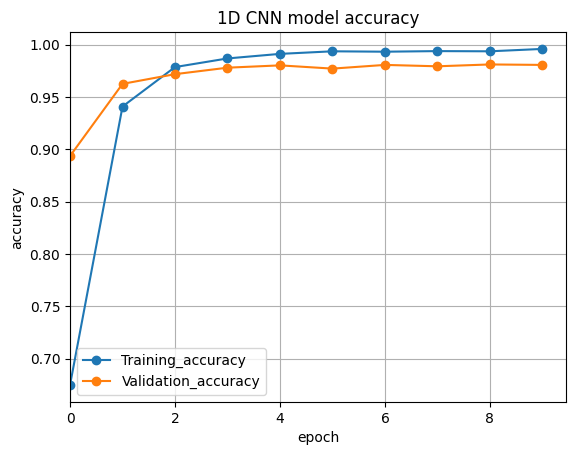

In [233]:
plt.plot(history_2.epoch, history_2.history['accuracy'], '-o', label='Training_accuracy')
plt.plot(history_2.epoch, history_2.history['val_accuracy'], '-o', label='Validation_accuracy')
plt.title('1D CNN model accuracy')
plt.grid(True)
plt.legend()
plt.xlim(left=0)
plt.xlabel('epoch')
plt.ylabel('accuracy')
# plt.savefig('1D_CNN__accuracy_metrics_'+ datetime.now().strftime("%Y%m%d_%H:%M:%S") + '.png', dpi=600, format='png', bbox_inches='tight')
# plt.savefig('1D_CNN__accuracy_metrics_'+ datetime.now().strftime("%Y%m%d_%H:%M:%S") + '.pdf', dpi=600, format='pdf', bbox_inches='tight')
plt.show()
plt.close()

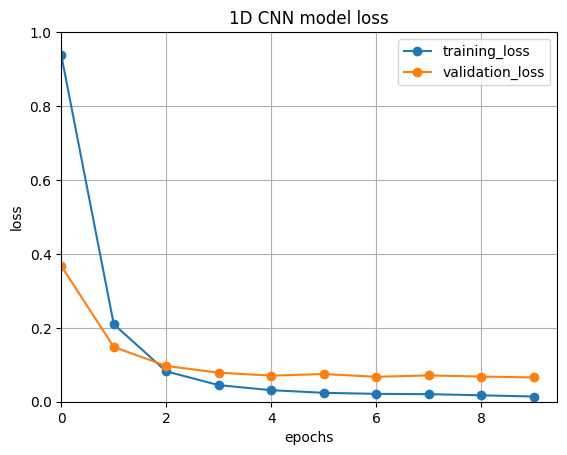

In [234]:
plt.plot(history_2.epoch, history_2.history['loss'], '-o', label='training_loss')
plt.plot(history_2.epoch, history_2.history['val_loss'], '-o', label='validation_loss')
plt.legend()
plt.title('1D CNN model loss')
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.grid(True)
plt.xlim(left=0)
plt.xlabel('epochs')
plt.ylabel('loss')
# plt.savefig('1D_CNN__loss_metrics_'+ datetime.now().strftime("%Y%m%d_%H:%M:%S") + '.png', dpi=600, format='png', bbox_inches='tight')
# plt.savefig('1D_CNN__loss_metrics_'+ datetime.now().strftime("%Y%m%d_%H:%M:%S") + '.pdf', dpi=600, format='pdf', bbox_inches='tight')
plt.show()
plt.close()

## BiLSTM MODEL

In [235]:
# %%time
X_train, X_test_unseen,  X_test, X_validate, y_train, y_test_unseen,y_test,y_validate = temp_X_train, temp_X_test_unseen,temp_X_test,temp_X_validate, temp_y_train, temp_y_test_unseen,temp_y_test,temp_y_validate


tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test_unseen = tokenizer.texts_to_sequences(X_test_unseen)
X_test = tokenizer.texts_to_sequences(X_test)
X_validate = tokenizer.texts_to_sequences(X_validate)

vocab_size = len(tokenizer.word_index) + 1
MAX_NB_WORDS = vocab_size
print(tokenizer.word_index)

max_length=max([len(i) for i in X_train])
print('Max len:', max_length)

X_train = pad_sequences(X_train, padding='post', maxlen=max_length)
X_test_unseen = pad_sequences(X_test_unseen, padding='post', maxlen=max_length)
X_test = pad_sequences(X_test, padding='post', maxlen=max_length)
X_validate = pad_sequences(X_validate, padding='post', maxlen=max_length)

y_test_unseen = to_categorical(y_test_unseen)
y_test = to_categorical(y_test)
y_train = to_categorical(y_train)
y_validate = to_categorical(y_validate)

### Cross validation ###
# X_train, y_train = temp_message, temp_label
# tokenizer_cross_val = Tokenizer()
# tokenizer_cross_val.fit_on_texts(X_train)

# X_train = tokenizer_cross_val.texts_to_sequences(X_train)

# vocab_size_cross_val = len(tokenizer_cross_val.word_index) + 1
# MAX_NB_WORDS = vocab_size_cross_val

# X_train = pad_sequences(X_train, padding='post', maxlen=max_length)
# y_train = to_categorical(y_train)


{'ค่า': 1, 'เอกสาร': 2, 'หรอ': 3, 'จ่าย': 4, 'จุด': 5, 'เทอม': 6, 'ไหม': 7, 'ถอน': 8, 'ซักไซ้': 9, 'ใบ': 10, 'วิชา': 11, 'เป็นนิสัย': 12, 'ตีพิมพ์': 13, 'หนู': 14, 'แจ้ง': 15, 'ผม': 16, 'ต้องการ': 17, 'อะ': 18, 'ขึ้นทะเบียน': 19, 'ลงทะเบียน': 20, 'เรื่อง': 21, 'ชำระ': 22, 'สวัสดี': 23, 'ประกาศนียบัตร': 24, 'ออนไลน์': 25, 'tu': 26, 'ทำ': 27, 'บัณฑิต': 28, 'นักศึกษา': 29, 'ไห': 30, 'นคะ': 31, 'กี่': 32, 'เรียน': 33, 'รายวิชา': 34, 'กด': 35, 'เงิน': 36, 'ภาคเรียน': 37, 'ตอนนี้': 38, 'ชำระเงิน': 39, 'แบบนี้': 40, 'ดีกรี': 41, 'รอ': 42, 'ป': 43, 'จดทะเบียน': 44, 'อ่ะ': 45, 'เบิก': 46, 'reg': 47, 'หน่วยกิต': 48, 'โควต้า': 49, 'ตอน': 50, 'ภาวะ': 51, 'นะคะ': 52, 'ชั่วโมง': 53, 'จบ': 54, 'transcript': 55, 'ตรวจสอบ': 56, 'ยื่น': 57, 'คณะ': 58, 'อันนี้': 59, 'เกาะ': 60, 'ซัมเมอร์': 61, 'ล่าช้า': 62, 'วันที่': 63, 'ทราบ': 64, 'มูลค่า': 65, 'ชั้น': 66, 'ศาสตร์': 67, 'หนังสือรับรอง': 68, 'w': 69, 'ค': 70, 'ฐานะ': 71, 'ท': 72, 'ติดต่อ': 73, 'รหัส': 74, 'เดินทาง': 75, 'บิล': 76, 'ทางไปรษณีย์': 77, 'กา

In [236]:
print('Train set size = {} \nTest set size = {}'.format(len(X_train),len(X_test_unseen)))

Train set size = 10559 
Test set size = 3772


In [237]:
#Model Definition
model_4 = Sequential()
model_4.add(Embedding(MAX_NB_WORDS, embed_dim, input_length=max_length))
# model.add(Dropout(0.25))
model_4.add(SpatialDropout1D(spa_dropout_ratio))

# model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, padding="valid", activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(GlobalMaxPooling1D())
# model.add(Dense(hidden_units, activation='relu'))
# model.add(Dropout(dropout_ratio))

model_4.add(Bidirectional(LSTM(lstm_units_1,return_sequences=True)))
# model.add(Dropout(dropout_ratio))
model_4.add(Bidirectional(LSTM(lstm_units_2)))
model_4.add(Dense(dense_units, activation='relu'))
model_4.add(Dropout(dropout_ratio))

model_4.add(Dense(7, activation='softmax'))
    
######################## COMPILING THE MODEL ##################################
model_4.compile(
    loss = "categorical_crossentropy", 
     optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate, decay=learning_decay),
#         optimizer='adam',
    metrics = [
        "accuracy",
#             "binary_accuracy",
             'categorical_accuracy',
#             tf.keras.metrics.AUC(),
#         tf.keras.metrics.Precision(),
#         tf.keras.metrics.Recall()
        ]
    )

print(model_4.summary())

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_66 (Embedding)    (None, 15, 300)           576600    
                                                                 
 spatial_dropout1d_99 (Spat  (None, 15, 300)           0         
 ialDropout1D)                                                   
                                                                 
 bidirectional_154 (Bidirec  (None, 15, 128)           186880    
 tional)                                                         
                                                                 
 bidirectional_155 (Bidirec  (None, 64)                41216     
 tional)                                                         
                                                                 
 dense_198 (Dense)           (None, 64)                4160      
                                                     

In [238]:
checkpoint = ModelCheckpoint("saved_model/"+"BiLSTM_"+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + ".h5", monitor='loss', verbose=1, save_best_only=True, mode='min')
earlystopping = EarlyStopping(
    monitor = 'loss',
    verbose = 1, 
    patience = 3, # Number of epochs with no improvement after which training will be stopped.
    mode = 'min'
)
callbacks_list = [checkpoint,earlystopping]

# fit network
start_time = time()
history_4 = model_4.fit(X_train, y_train,batch_size=batch_size, epochs=epochs, verbose=1,callbacks=callbacks_list,validation_data=(X_validate, y_validate))
train_time = time() - start_time
print(train_time)

Epoch 1/10
164/165 [============================>.] - ETA: 0s - loss: 0.8730 - accuracy: 0.6966 - categorical_accuracy: 0.6966
Epoch 1: loss improved from inf to 0.86943, saving model to saved_model/BiLSTM_20240210_16-27-31.h5
165/165 [==============================] - 6s 23ms/step - loss: 0.8694 - accuracy: 0.6977 - categorical_accuracy: 0.6977 - val_loss: 0.3273 - val_accuracy: 0.8958 - val_categorical_accuracy: 0.8958
Epoch 2/10
 10/165 [>.............................] - ETA: 2s - loss: 0.2618 - accuracy: 0.9172 - categorical_accuracy: 0.9172

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


165/165 [==============================] - ETA: 0s - loss: 0.2238 - accuracy: 0.9338 - categorical_accuracy: 0.9338
Epoch 2: loss improved from 0.86943 to 0.22376, saving model to saved_model/BiLSTM_20240210_16-27-31.h5
165/165 [==============================] - 3s 20ms/step - loss: 0.2238 - accuracy: 0.9338 - categorical_accuracy: 0.9338 - val_loss: 0.1965 - val_accuracy: 0.9435 - val_categorical_accuracy: 0.9435
Epoch 3/10
165/165 [==============================] - ETA: 0s - loss: 0.1327 - accuracy: 0.9606 - categorical_accuracy: 0.9606
Epoch 3: loss improved from 0.22376 to 0.13269, saving model to saved_model/BiLSTM_20240210_16-27-31.h5
165/165 [==============================] - 3s 20ms/step - loss: 0.1327 - accuracy: 0.9606 - categorical_accuracy: 0.9606 - val_loss: 0.1409 - val_accuracy: 0.9607 - val_categorical_accuracy: 0.9607
Epoch 4/10
165/165 [==============================] - ETA: 0s - loss: 0.0925 - accuracy: 0.9726 - categorical_accuracy: 0.9726
Epoch 4: loss improved fro

In [239]:
# Test 15%
predicted = model_4.predict(X_test)

predicted = np.argmax(predicted, axis=1)
y_test = np.argmax(y_test,axis=1)

# report = classification_report(y_test_unseen, predicted, output_dict=True)
report = classification_report(y_test, predicted, digits=4)
print(report)


# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, predicted)
print('Testing Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, predicted,average='weighted')
print('Testing Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, predicted,average='weighted')
print('Testing Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, predicted,average='weighted')
print('Testing F1 score: %f' % f1)


71/71 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0     0.9810    0.9854    0.9832       683
           1     0.9902    0.9748    0.9824       516
           2     0.9759    0.9643    0.9701        84
           3     0.9807    0.9876    0.9841       565
           4     0.9722    0.9859    0.9790        71
           5     0.9882    0.9655    0.9767        87
           6     0.9693    0.9806    0.9750       258

    accuracy                         0.9814      2264
   macro avg     0.9797    0.9777    0.9786      2264
weighted avg     0.9815    0.9814    0.9814      2264

Testing Accuracy: 0.981449
Testing Precision: 0.981505
Testing Recall: 0.981449
Testing F1 score: 0.981447


In [240]:
df_results.loc['BiLSTM Test 15%'] = [f1, precision, recall, accuracy, train_time]
df_results

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM Test 15%,0.983170,0.983289,0.983216,0.983216,20.757635
Att-Based CNN-BiLSTM Validate 15%,0.982764,0.982835,0.982774,0.982774,20.757635
Att-Based CNN-BiLSTM Test unseen 20%,0.982501,0.982676,0.982503,0.982503,20.757635
CNN-BiLSTM Test 15%,0.980546,0.980655,0.980565,0.980565,19.530745
CNN-BiLSTM Validate 15%,0.979701,0.979894,0.979682,0.979682,19.530745
CNN-BiLSTM Test unseen 20%,0.983021,0.983135,0.983033,0.983033,19.530745
1D_CNN Test 15%,0.986737,0.986807,0.986749,0.986749,7.869317
1D_CNN Test unseen 20%,0.987538,0.987607,0.987540,0.987540,7.869317
1D_CNN Validate 15%,0.980580,0.980726,0.980565,0.980565,7.869317
BiLSTM Test 15%,0.981447,0.981505,0.981449,0.981449,35.164423


In [241]:
# Validate 15%
predicted_val = model_4.predict(X_validate)

predicted_val = np.argmax(predicted_val, axis=1)
y_validate = np.argmax(y_validate,axis=1)

report = classification_report(y_validate, predicted_val, digits=4)
print(report)

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_validate, predicted_val)
print('Testing Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_validate, predicted_val,average='weighted')
print('Testing Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_validate, predicted_val,average='weighted')
print('Testing Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_validate, predicted_val,average='weighted')
print('Testing F1 score: %f' % f1)

df_results.loc['BiLSTM Validate 15%'] = [f1, precision, recall, accuracy, train_time]
df_results

 1/71 [..............................] - ETA: 0s

71/71 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0     0.9810    0.9868    0.9839       682
           1     0.9824    0.9729    0.9776       516
           2     0.9877    0.9524    0.9697        84
           3     0.9806    0.9823    0.9814       565
           4     0.9211    0.9859    0.9524        71
           5     0.9663    0.9773    0.9718        88
           6     0.9843    0.9729    0.9786       258

    accuracy                         0.9792      2264
   macro avg     0.9719    0.9758    0.9736      2264
weighted avg     0.9794    0.9792    0.9793      2264

Testing Accuracy: 0.979240
Testing Precision: 0.979396
Testing Recall: 0.979240
Testing F1 score: 0.979258


,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM Test 15%,0.983170,0.983289,0.983216,0.983216,20.757635
Att-Based CNN-BiLSTM Validate 15%,0.982764,0.982835,0.982774,0.982774,20.757635
Att-Based CNN-BiLSTM Test unseen 20%,0.982501,0.982676,0.982503,0.982503,20.757635
CNN-BiLSTM Test 15%,0.980546,0.980655,0.980565,0.980565,19.530745
CNN-BiLSTM Validate 15%,0.979701,0.979894,0.979682,0.979682,19.530745
CNN-BiLSTM Test unseen 20%,0.983021,0.983135,0.983033,0.983033,19.530745
1D_CNN Test 15%,0.986737,0.986807,0.986749,0.986749,7.869317
1D_CNN Test unseen 20%,0.987538,0.987607,0.987540,0.987540,7.869317
1D_CNN Validate 15%,0.980580,0.980726,0.980565,0.980565,7.869317
BiLSTM Test 15%,0.981447,0.981505,0.981449,0.981449,35.164423


In [242]:
predicted = model_4.predict(X_test_unseen)

predicted = np.argmax(predicted, axis=1)
y_test_unseen = np.argmax(y_test_unseen,axis=1)

# report = classification_report(y_test_unseen, predicted, output_dict=True)
report = classification_report(y_test_unseen, predicted, digits=4)
print(report)
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test_unseen, predicted)
print('Testing Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test_unseen, predicted,average='weighted')
print('Testing Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test_unseen, predicted,average='weighted')
print('Testing Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test_unseen, predicted,average='weighted')
print('Testing F1 score: %f' % f1)

118/118 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0     0.9826    0.9938    0.9882      1137
           1     0.9917    0.9744    0.9830       861
           2     1.0000    0.9929    0.9964       140
           3     0.9842    0.9936    0.9889       941
           4     0.9828    0.9661    0.9744       118
           5     0.9928    0.9452    0.9684       146
           6     0.9838    0.9907    0.9872       429

    accuracy                         0.9862      3772
   macro avg     0.9883    0.9795    0.9838      3772
weighted avg     0.9863    0.9862    0.9862      3772

Testing Accuracy: 0.986214
Testing Precision: 0.986269
Testing Recall: 0.986214
Testing F1 score: 0.986183


In [243]:
# append the results
df_results.loc['BiLSTM Test unseen 20%'] = [f1, precision, recall, accuracy, train_time]
df_results

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM Test 15%,0.983170,0.983289,0.983216,0.983216,20.757635
Att-Based CNN-BiLSTM Validate 15%,0.982764,0.982835,0.982774,0.982774,20.757635
Att-Based CNN-BiLSTM Test unseen 20%,0.982501,0.982676,0.982503,0.982503,20.757635
CNN-BiLSTM Test 15%,0.980546,0.980655,0.980565,0.980565,19.530745
CNN-BiLSTM Validate 15%,0.979701,0.979894,0.979682,0.979682,19.530745
CNN-BiLSTM Test unseen 20%,0.983021,0.983135,0.983033,0.983033,19.530745
1D_CNN Test 15%,0.986737,0.986807,0.986749,0.986749,7.869317
1D_CNN Test unseen 20%,0.987538,0.987607,0.987540,0.987540,7.869317
1D_CNN Validate 15%,0.980580,0.980726,0.980565,0.980565,7.869317
BiLSTM Test 15%,0.981447,0.981505,0.981449,0.981449,35.164423


In [244]:
# Number of folds
num_folds = 10

# Create a StratifiedKFold object
kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

accuracy_scores_bilstm = []
precision_scores_bilstm = []
f1_scores_bilstm = []
recall_scores_bilstm = []

X, y_encoded = X_train, y_train
total_train_time = 0  # Initialize total training time
# Perform cross-validation
fold_var=0
for i, (train_index, test_index) in enumerate(kf.split(X, y_encoded.argmax(1))):
    fold_var +=1
    print("------ Fold ----------", fold_var)
    X_train, X_val = X[train_index], X[test_index]
    y_train, y_val = y_encoded[train_index], y_encoded[test_index]

    # Define your Keras model
    cross_bilstm_model = Sequential()
    cross_bilstm_model.add(Embedding(MAX_NB_WORDS, embed_dim, input_length=max_length))
    cross_bilstm_model.add(SpatialDropout1D(spa_dropout_ratio))
    cross_bilstm_model.add(Bidirectional(LSTM(lstm_units_1, return_sequences=True)))
    cross_bilstm_model.add(Bidirectional(LSTM(lstm_units_2)))
    cross_bilstm_model.add(Dense(dense_units, activation='relu'))
    cross_bilstm_model.add(Dropout(dropout_ratio))
    cross_bilstm_model.add(Dense(7, activation='softmax'))

    # Compile the model
    cross_bilstm_model.compile(
        loss="categorical_crossentropy",
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate, decay=learning_decay),
       metrics = [
        "accuracy",
#             "binary_accuracy",
             'categorical_accuracy',
#             tf.keras.metrics.AUC(),
#         tf.keras.metrics.Precision(),
#         tf.keras.metrics.Recall()
        ]
    )
    
    ######################## MODEL SAVING/OVERFITTING MANAGEMENT ##################################
   
    check_point = ModelCheckpoint(bisltm_cross_validate_model_path, monitor="val_loss", verbose=1, save_best_only=True, mode="min")
    early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=3, verbose=1)

    # Train the model
    start_time = time()
    cross_bilstm_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), verbose=1, callbacks=[check_point,early_stop])
    total_train_time += train_time
    
    y_pred=np.argmax(cross_bilstm_model.predict(X_val), axis=-1)
    y_true_validation_test = np.argmax(y_val,axis = 1)
    
    accuracy_scores_bilstm.append(accuracy_score(y_true_validation_test, y_pred))
    precision_scores_bilstm.append(precision_score(y_true_validation_test, y_pred, average='weighted'))
    f1_scores_bilstm.append(f1_score(y_true_validation_test, y_pred, average='weighted'))
    recall_scores_bilstm.append(f1_score(y_true_validation_test, y_pred, average='weighted'))

------ Fold ---------- 1


Epoch 1/10
295/297 [============================>.] - ETA: 0s - loss: 0.7352 - accuracy: 0.7437 - categorical_accuracy: 0.7437
Epoch 1: val_loss improved from inf to 0.33366, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
297/297 [==============================] - 7s 15ms/step - loss: 0.7327 - accuracy: 0.7443 - categorical_accuracy: 0.7443 - val_loss: 0.3337 - val_accuracy: 0.8920 - val_categorical_accuracy: 0.8920
Epoch 2/10
 13/297 [>.............................] - ETA: 3s - loss: 0.3166 - accuracy: 0.9062 - categorical_accuracy: 0.9062

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


297/297 [==============================] - ETA: 0s - loss: 0.2126 - accuracy: 0.9352 - categorical_accuracy: 0.9352
Epoch 2: val_loss improved from 0.33366 to 0.16141, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
297/297 [==============================] - 4s 13ms/step - loss: 0.2126 - accuracy: 0.9352 - categorical_accuracy: 0.9352 - val_loss: 0.1614 - val_accuracy: 0.9583 - val_categorical_accuracy: 0.9583
Epoch 3/10
297/297 [==============================] - ETA: 0s - loss: 0.1191 - accuracy: 0.9665 - categorical_accuracy: 0.9665
Epoch 3: val_loss improved from 0.16141 to 0.11114, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
297/297 [==============================] - 4s 13ms/step - loss: 0.1191 - accuracy: 0.9665 - categorical_accuracy: 0.9665 - val_loss: 0.1111 - val_accuracy: 0.9688 - val_categorical_accuracy: 0.9688
Epoch 4/10
293/297 [============================>.] - ETA: 0s - loss: 0.0797 - accuracy: 0.9765 - categorical_accuracy: 0.9765
Epoch 

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


294/297 [============================>.] - ETA: 0s - loss: 0.2123 - accuracy: 0.9401 - categorical_accuracy: 0.9401
Epoch 2: val_loss improved from 0.33929 to 0.17338, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
297/297 [==============================] - 4s 14ms/step - loss: 0.2111 - accuracy: 0.9402 - categorical_accuracy: 0.9402 - val_loss: 0.1734 - val_accuracy: 0.9564 - val_categorical_accuracy: 0.9564
Epoch 3/10
297/297 [==============================] - ETA: 0s - loss: 0.1082 - accuracy: 0.9697 - categorical_accuracy: 0.9697
Epoch 3: val_loss improved from 0.17338 to 0.14548, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
297/297 [==============================] - 4s 14ms/step - loss: 0.1082 - accuracy: 0.9697 - categorical_accuracy: 0.9697 - val_loss: 0.1455 - val_accuracy: 0.9574 - val_categorical_accuracy: 0.9574
Epoch 4/10
296/297 [============================>.] - ETA: 0s - loss: 0.0755 - accuracy: 0.9811 - categorical_accuracy: 0.9811
Epoch 

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


297/297 [==============================] - ETA: 0s - loss: 0.1930 - accuracy: 0.9455 - categorical_accuracy: 0.9455
Epoch 2: val_loss improved from 0.32652 to 0.14286, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
297/297 [==============================] - 4s 14ms/step - loss: 0.1930 - accuracy: 0.9455 - categorical_accuracy: 0.9455 - val_loss: 0.1429 - val_accuracy: 0.9574 - val_categorical_accuracy: 0.9574
Epoch 3/10
297/297 [==============================] - ETA: 0s - loss: 0.1063 - accuracy: 0.9720 - categorical_accuracy: 0.9720
Epoch 3: val_loss improved from 0.14286 to 0.10935, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
297/297 [==============================] - 4s 14ms/step - loss: 0.1063 - accuracy: 0.9720 - categorical_accuracy: 0.9720 - val_loss: 0.1094 - val_accuracy: 0.9621 - val_categorical_accuracy: 0.9621
Epoch 4/10
294/297 [============================>.] - ETA: 0s - loss: 0.0806 - accuracy: 0.9776 - categorical_accuracy: 0.9776
Epoch 

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


295/297 [============================>.] - ETA: 0s - loss: 0.1575 - accuracy: 0.9530 - categorical_accuracy: 0.9530
Epoch 2: val_loss improved from 0.21606 to 0.10802, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
297/297 [==============================] - 4s 14ms/step - loss: 0.1569 - accuracy: 0.9532 - categorical_accuracy: 0.9532 - val_loss: 0.1080 - val_accuracy: 0.9669 - val_categorical_accuracy: 0.9669
Epoch 3/10
297/297 [==============================] - ETA: 0s - loss: 0.0953 - accuracy: 0.9717 - categorical_accuracy: 0.9717
Epoch 3: val_loss improved from 0.10802 to 0.08349, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
297/297 [==============================] - 4s 14ms/step - loss: 0.0953 - accuracy: 0.9717 - categorical_accuracy: 0.9717 - val_loss: 0.0835 - val_accuracy: 0.9744 - val_categorical_accuracy: 0.9744
Epoch 4/10
294/297 [============================>.] - ETA: 0s - loss: 0.0622 - accuracy: 0.9825 - categorical_accuracy: 0.9825
Epoch 

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


296/297 [============================>.] - ETA: 0s - loss: 0.2251 - accuracy: 0.9357 - categorical_accuracy: 0.9357
Epoch 2: val_loss improved from 0.39916 to 0.15294, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
297/297 [==============================] - 4s 13ms/step - loss: 0.2247 - accuracy: 0.9358 - categorical_accuracy: 0.9358 - val_loss: 0.1529 - val_accuracy: 0.9574 - val_categorical_accuracy: 0.9574
Epoch 3/10
295/297 [============================>.] - ETA: 0s - loss: 0.1165 - accuracy: 0.9673 - categorical_accuracy: 0.9673
Epoch 3: val_loss improved from 0.15294 to 0.10589, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
297/297 [==============================] - 4s 13ms/step - loss: 0.1160 - accuracy: 0.9674 - categorical_accuracy: 0.9674 - val_loss: 0.1059 - val_accuracy: 0.9744 - val_categorical_accuracy: 0.9744
Epoch 4/10
296/297 [============================>.] - ETA: 0s - loss: 0.0764 - accuracy: 0.9769 - categorical_accuracy: 0.9769
Epoch 

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


295/297 [============================>.] - ETA: 0s - loss: 0.2442 - accuracy: 0.9282 - categorical_accuracy: 0.9282
Epoch 2: val_loss improved from 0.35126 to 0.18883, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
297/297 [==============================] - 4s 13ms/step - loss: 0.2447 - accuracy: 0.9279 - categorical_accuracy: 0.9279 - val_loss: 0.1888 - val_accuracy: 0.9403 - val_categorical_accuracy: 0.9403
Epoch 3/10
295/297 [============================>.] - ETA: 0s - loss: 0.1306 - accuracy: 0.9627 - categorical_accuracy: 0.9627
Epoch 3: val_loss improved from 0.18883 to 0.13951, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
297/297 [==============================] - 4s 13ms/step - loss: 0.1313 - accuracy: 0.9627 - categorical_accuracy: 0.9627 - val_loss: 0.1395 - val_accuracy: 0.9574 - val_categorical_accuracy: 0.9574
Epoch 4/10
294/297 [============================>.] - ETA: 0s - loss: 0.0875 - accuracy: 0.9737 - categorical_accuracy: 0.9737
Epoch 

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


294/297 [============================>.] - ETA: 0s - loss: 0.1889 - accuracy: 0.9467 - categorical_accuracy: 0.9467
Epoch 2: val_loss improved from 0.24992 to 0.13296, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
297/297 [==============================] - 4s 14ms/step - loss: 0.1885 - accuracy: 0.9468 - categorical_accuracy: 0.9468 - val_loss: 0.1330 - val_accuracy: 0.9564 - val_categorical_accuracy: 0.9564
Epoch 3/10
294/297 [============================>.] - ETA: 0s - loss: 0.0982 - accuracy: 0.9713 - categorical_accuracy: 0.9713
Epoch 3: val_loss did not improve from 0.13296
297/297 [==============================] - 4s 14ms/step - loss: 0.0975 - accuracy: 0.9716 - categorical_accuracy: 0.9716 - val_loss: 0.1375 - val_accuracy: 0.9602 - val_categorical_accuracy: 0.9602
Epoch 4/10
295/297 [============================>.] - ETA: 0s - loss: 0.0750 - accuracy: 0.9785 - categorical_accuracy: 0.9785
Epoch 4: val_loss improved from 0.13296 to 0.08475, saving model to saved

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


297/297 [==============================] - ETA: 0s - loss: 0.1794 - accuracy: 0.9455 - categorical_accuracy: 0.9455
Epoch 2: val_loss improved from 0.34830 to 0.17191, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
297/297 [==============================] - 4s 14ms/step - loss: 0.1794 - accuracy: 0.9455 - categorical_accuracy: 0.9455 - val_loss: 0.1719 - val_accuracy: 0.9451 - val_categorical_accuracy: 0.9451
Epoch 3/10
294/297 [============================>.] - ETA: 0s - loss: 0.1012 - accuracy: 0.9703 - categorical_accuracy: 0.9703
Epoch 3: val_loss improved from 0.17191 to 0.14758, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
297/297 [==============================] - 4s 14ms/step - loss: 0.1013 - accuracy: 0.9703 - categorical_accuracy: 0.9703 - val_loss: 0.1476 - val_accuracy: 0.9621 - val_categorical_accuracy: 0.9621
Epoch 4/10
296/297 [============================>.] - ETA: 0s - loss: 0.0692 - accuracy: 0.9792 - categorical_accuracy: 0.9792
Epoch 

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


297/297 [==============================] - ETA: 0s - loss: 0.1968 - accuracy: 0.9438 - categorical_accuracy: 0.9438
Epoch 2: val_loss improved from 0.31857 to 0.20730, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
297/297 [==============================] - 4s 14ms/step - loss: 0.1968 - accuracy: 0.9438 - categorical_accuracy: 0.9438 - val_loss: 0.2073 - val_accuracy: 0.9441 - val_categorical_accuracy: 0.9441
Epoch 3/10
295/297 [============================>.] - ETA: 0s - loss: 0.1066 - accuracy: 0.9706 - categorical_accuracy: 0.9706
Epoch 3: val_loss improved from 0.20730 to 0.14520, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
297/297 [==============================] - 4s 14ms/step - loss: 0.1062 - accuracy: 0.9706 - categorical_accuracy: 0.9706 - val_loss: 0.1452 - val_accuracy: 0.9555 - val_categorical_accuracy: 0.9555
Epoch 4/10
294/297 [============================>.] - ETA: 0s - loss: 0.0747 - accuracy: 0.9778 - categorical_accuracy: 0.9778
Epoch 

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


295/297 [============================>.] - ETA: 0s - loss: 0.2115 - accuracy: 0.9364 - categorical_accuracy: 0.9364
Epoch 2: val_loss improved from 0.33158 to 0.17342, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
297/297 [==============================] - 4s 13ms/step - loss: 0.2110 - accuracy: 0.9366 - categorical_accuracy: 0.9366 - val_loss: 0.1734 - val_accuracy: 0.9479 - val_categorical_accuracy: 0.9479
Epoch 3/10
293/297 [============================>.] - ETA: 0s - loss: 0.1233 - accuracy: 0.9663 - categorical_accuracy: 0.9663
Epoch 3: val_loss improved from 0.17342 to 0.14668, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
297/297 [==============================] - 4s 13ms/step - loss: 0.1226 - accuracy: 0.9666 - categorical_accuracy: 0.9666 - val_loss: 0.1467 - val_accuracy: 0.9536 - val_categorical_accuracy: 0.9536
Epoch 4/10
296/297 [============================>.] - ETA: 0s - loss: 0.0898 - accuracy: 0.9733 - categorical_accuracy: 0.9733
Epoch 

In [245]:
accuracy_avg_bilstm = sum(accuracy_scores_bilstm) / len(accuracy_scores_bilstm)
precision_avg_bilstm = sum(precision_scores_bilstm) / len(precision_scores_bilstm)
recall_avg_bilstm = sum(recall_scores_bilstm) / len(recall_scores_bilstm)
f1_avg_bilstm = sum(f1_scores_bilstm) / len(f1_scores_bilstm)

results_df = pd.DataFrame({
    'Fold': list(range(1, num_folds+1)),
    'Accuracy': accuracy_scores_bilstm,
    'Precision': precision_scores_bilstm,
    'Recall': recall_scores_bilstm,
    'F1 Score': f1_scores_bilstm
 
})
results_df.loc[num_folds] = ['Avg.', accuracy_avg_bilstm,precision_avg_bilstm,recall_avg_bilstm,f1_avg_bilstm]
print(results_df.to_markdown(index=False))


| Fold   |   Accuracy |   Precision |   Recall |   F1 Score |
|:-------|-----------:|------------:|---------:|-----------:|
| 1      |   0.975379 |    0.975997 | 0.974709 |   0.974709 |
| 2      |   0.969697 |    0.970066 | 0.969684 |   0.969684 |
| 3      |   0.969697 |    0.969985 | 0.969722 |   0.969722 |
| 4      |   0.982008 |    0.982124 | 0.982029 |   0.982029 |
| 5      |   0.979167 |    0.979243 | 0.979132 |   0.979132 |
| 6      |   0.982955 |    0.983047 | 0.982916 |   0.982916 |
| 7      |   0.977273 |    0.977481 | 0.977331 |   0.977331 |
| 8      |   0.980114 |    0.9802   | 0.98012  |   0.98012  |
| 9      |   0.970644 |    0.971197 | 0.970624 |   0.970624 |
| 10     |   0.982938 |    0.983138 | 0.982936 |   0.982936 |
| Avg.   |   0.976987 |    0.977248 | 0.97692  |   0.97692  |


### **Plotting the results**

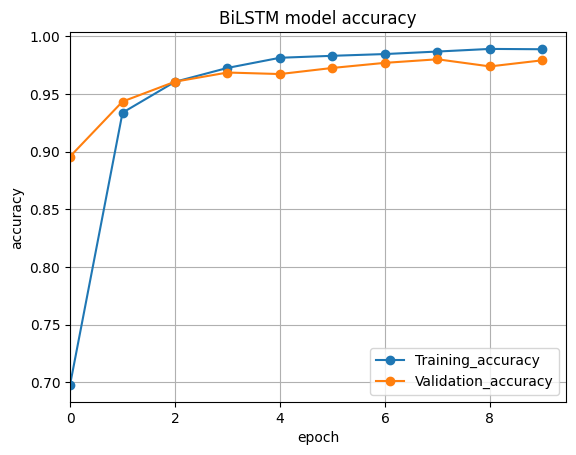

In [246]:
plt.plot(history_4.epoch, history_4.history['accuracy'], '-o', label='Training_accuracy')
plt.plot(history_4.epoch, history_4.history['val_accuracy'], '-o', label='Validation_accuracy')
plt.title('BiLSTM model accuracy')
plt.grid(True)
plt.legend()
plt.xlim(left=0)
plt.xlabel('epoch')
plt.ylabel('accuracy')
# plt.savefig('BiLSTM_accuracy_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.png', dpi=600, format='png', bbox_inches='tight')
# plt.savefig('BiLSTM_accuracy_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.pdf', dpi=600, format='pdf', bbox_inches='tight')
plt.show()
plt.close()

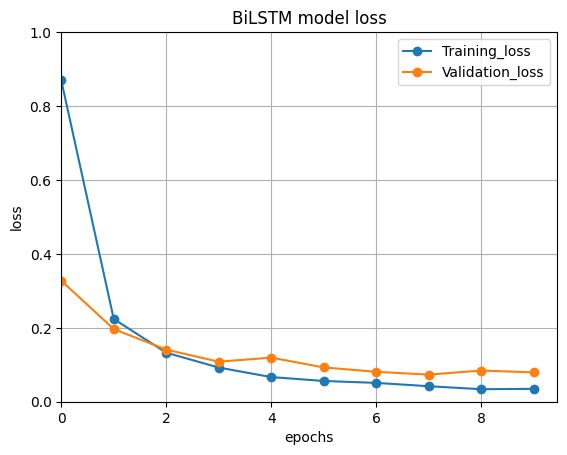

In [247]:
plt.plot(history_4.epoch, history_4.history['loss'], '-o', label='Training_loss')
plt.plot(history_4.epoch, history_4.history['val_loss'], '-o', label='Validation_loss')
plt.legend()
plt.title('BiLSTM model loss')
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.grid(True)
plt.xlim(left=0)
plt.xlabel('epochs')
plt.ylabel('loss')
# plt.savefig('BiLSTM_loss_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.png', dpi=600, format='png', bbox_inches='tight')
# plt.savefig('BiLSTM_loss_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.pdf', dpi=600, format='pdf', bbox_inches='tight')
plt.show()
plt.close()

In [248]:
# plot_classification_report(report)
# plt.savefig('BiLSTM_plot_classif_report_'+ datetime.now().strftime("%Y%m%d_%H-%M%S") + '.png', dpi=600, format='png', bbox_inches='tight')
# plt.close()

AVG. Cross validation

In [249]:
df_results_cross_val.loc['BiLSTM avg cross validation data test 80%'] = [f1_avg_bilstm, precision_avg_bilstm, recall_avg_bilstm, accuracy_avg_bilstm, total_train_time]
df_results_cross_val

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM avg cross validation data test 80%,0.973766,0.974320,0.973766,0.973767,207.576349
Att-Based CNN-BiLSTM avg cross validation data test 20%,0.981420,0.981496,0.981442,0.981442,20.757635
CNN-BiLSTM avg cross validation data train 80%,0.975705,0.976133,0.975705,0.975754,195.307448
CNN-BiLSTM avg cross validation data test 20%,0.974537,0.974580,0.974549,0.974549,19.530745
1D_CNN avg cross validation data test 80%,0.983046,0.983214,0.983046,0.983047,78.693171
1D_CNN avg cross validation data test 20%,0.985419,0.985454,0.985419,0.985419,7.869317
BiLSTM avg cross validation data test 80%,0.976920,0.977248,0.976920,0.976987,351.644230


In [250]:
# Test cross validation 20%
model_bisltm_cross_validate = load_model(bisltm_cross_validate_model_path)
predicted = model_bisltm_cross_validate.predict(X_test_unseen)

predicted = np.argmax(predicted, axis=1)
# y_test = np.argmax(y_test_unseen,axis=1)

# report = classification_report(y_test_unseen, predicted, output_dict=True)
report = classification_report(y_test_unseen, predicted, digits=4)
# print(report)


# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test_unseen, predicted)
print('Testing Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test_unseen, predicted,average='weighted')
print('Testing Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test_unseen, predicted,average='weighted')
print('Testing Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test_unseen, predicted,average='weighted')
print('Testing F1 score: %f' % f1)

118/118 [==============================] - 1s 3ms/step
Testing Accuracy: 0.982238
Testing Precision: 0.982447
Testing Recall: 0.982238
Testing F1 score: 0.982231


In [251]:

df_results_cross_val.loc['BiLSTM avg cross validation data test 20%'] = [f1, precision, recall, accuracy, train_time]
df_results_cross_val

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM avg cross validation data test 80%,0.973766,0.974320,0.973766,0.973767,207.576349
Att-Based CNN-BiLSTM avg cross validation data test 20%,0.981420,0.981496,0.981442,0.981442,20.757635
CNN-BiLSTM avg cross validation data train 80%,0.975705,0.976133,0.975705,0.975754,195.307448
CNN-BiLSTM avg cross validation data test 20%,0.974537,0.974580,0.974549,0.974549,19.530745
1D_CNN avg cross validation data test 80%,0.983046,0.983214,0.983046,0.983047,78.693171
1D_CNN avg cross validation data test 20%,0.985419,0.985454,0.985419,0.985419,7.869317
BiLSTM avg cross validation data test 80%,0.976920,0.977248,0.976920,0.976987,351.644230
BiLSTM avg cross validation data test 20%,0.982231,0.982447,0.982238,0.982238,35.164423


## save the results in csv

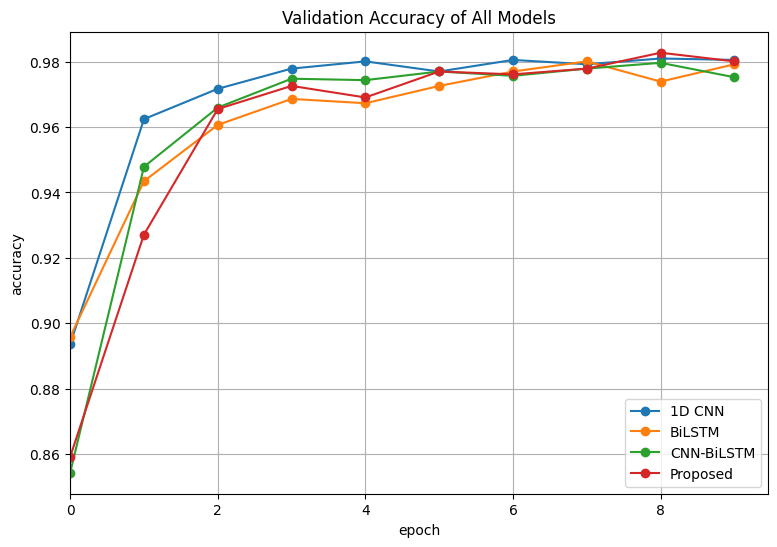

In [252]:
# plot overall accuracy on test set
fig = plt.figure(figsize=(9,6))
plt.plot(history_2.epoch, history_2.history['val_accuracy'], '-o', label='1D CNN')
# plt.plot(history_3.epoch, history_3.history['val_accuracy'], '-o', label='LSTM')
plt.plot(history_4.epoch, history_4.history['val_accuracy'], '-o', label='BiLSTM')
plt.plot(history_5.epoch, history_5.history['val_accuracy'], '-o', label='CNN-BiLSTM')
plt.plot(history_1.epoch, history_1.history['val_accuracy'], '-o', label='Proposed')
plt.title('Validation Accuracy of All Models')
plt.grid(True)
plt.legend()
plt.xlim(left=0)
plt.xlabel('epoch')
plt.ylabel('accuracy')
# plt.savefig('All_models_accuracy_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.png', dpi=600, format='png', bbox_inches='tight')
# plt.savefig('All_models_accuracy_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.pdf', dpi=600, format='pdf', bbox_inches='tight')
plt.show()
plt.close()

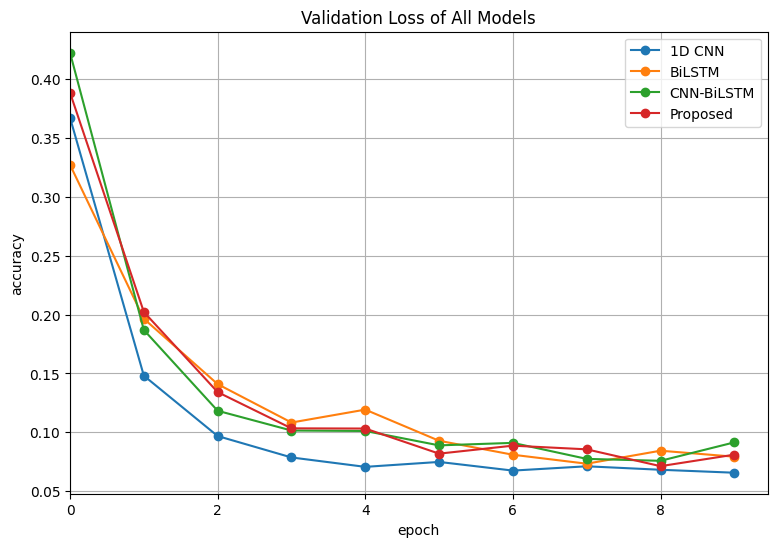

In [253]:
# plot overall looss on test set
fig = plt.figure(figsize=(9,6))
plt.plot(history_2.epoch, history_2.history['val_loss'], '-o', label='1D CNN')
# plt.plot(history_3.epoch, history_3.history['val_loss'], '-o', label='LSTM')
plt.plot(history_4.epoch, history_4.history['val_loss'], '-o', label='BiLSTM')
plt.plot(history_5.epoch, history_5.history['val_loss'], '-o', label='CNN-BiLSTM')
plt.plot(history_1.epoch, history_1.history['val_loss'], '-o', label='Proposed')
plt.title('Validation Loss of All Models')
plt.grid(True)
plt.legend()
plt.xlim(left=0)
plt.xlabel('epoch')
plt.ylabel('accuracy')
# plt.savefig('All_models_val_loss_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.png', dpi=600, format='png', bbox_inches='tight')
# plt.savefig('All_models_val_loss_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.pdf', dpi=600, format='pdf', bbox_inches='tight')
plt.show()
plt.close()